In [1]:
#libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import time
import pickle
import seaborn as sns
from numpy import linalg as LA
from mpl_toolkits import mplot3d
from scipy import signal
from collections import Counter
from collections import defaultdict
from datetime import datetime, timedelta
from yahoo_fin.stock_info import get_data
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

# Introduction to Cryptocurrency Market State Identification

Cryptocurrencies are a relatively new asset class. The market as a whole has a $1T+ market cap. As such, it's important to unveil properties of this market. To anyone who has casually observed cryptocurrency asset prices it seems like price movements are correlated across assets. Can these correlated price movements give us a hint as to how we can perform better investments in the market?
In this project, we try to indentify in a systematic way how many generic correlation patterns occur in the cryptocurrency market. These generic correlation patterns take on the moniker of "market states." 
We identify 4 market states in the cryptocurrency market, the two most important ones being the "rally state" and "crash state". The rally state sees an average daily return of 1.05\% while the crash state sees an average daily loss of 0.75\%. 
From this analysis, we can compute the probabilities of transitioning from any of the four market states into the rally or crash state. These probabilities can be used in portfolio rebalancing or hedging dependent on risk tolerance.

#  Determining Cryptos for Analysis

Given that cryptocurrencies are relatively new, we need to find assets with enough data for this analysis. Here we look at the top 500 cryptocurrencies by market cap as of today. Of these, we look find that our criteria to be considered is having 4 years worth of price data on Yahoo Finance. We also filter out stable coins as their prices should not be correlated at all with other cryptocurrencies.

In [2]:
# getting TODAY's date
today = datetime.strftime(datetime.today(), "%m%d%y")

In [3]:
# defining function to read data from a given url
def getdata(url):
    r = requests.get(url,headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})
    data = pd.read_html(r.text)
    return data

In [4]:
# defining function to get top 500 cryptos by marketcap off yahoo finance
def crypto_meta_marketcap(n_count=500):
    home = 'https://finance.yahoo.com/cryptocurrencies/'
    count = 100
    n_offset = n_count//count
    
    cryptos = None
    for o in range(n_offset):
        url = f'{home}?offset={o*100}&count={count}'
        df = getdata(url)[0]
        if cryptos is None:
            cryptos = pd.DataFrame(index=range(n_count), columns=df.columns)
        # print(cryptos, cryptos.loc[o*count:(o+1)*count], df, df.values)
        # print(len(cryptos), len(df.values))
        cryptos.iloc[o*count:(o+1)*count] = df
        
    return cryptos

In [5]:
# make function to give you a dictionary with symbol and close prices for each crypto for the entire analysis time
# start and end date as string 'm/d/y'
# time interval as string ex: '1wk'
def analysisdata(symbols, startdate, enddate, tinterval):
    series = dict()
    for i in symbols:
        series[i] = get_data(i, start_date=startdate, end_date=enddate, index_as_date=True, interval=tinterval)['close']
    return series

In [350]:
# return a df of those top 500 cryptos
c = crypto_meta_marketcap()
c.head()

Symbol                   Name Price (Intraday)    Change % Change  \
0     BTC-USD            Bitcoin USD         19240.26   -240.54   -1.23%   
1     ETH-USD           Ethereum USD          1306.01    -15.39   -1.16%   
2    USDT-USD             Tether USD              1.0   -0.0001   -0.01%   
3    USDC-USD           USD Coin USD           1.0001    0.0001   +0.01%   
4     BNB-USD                BNB USD           274.92     -3.34   -1.20%   
..        ...                    ...              ...       ...      ...   
495   UPP-USD  Sentinel Protocol USD         0.061482 -0.001003   -1.60%   
496   BLZ-USD           Bluzelle USD         0.082574 -0.001225   -1.46%   
497    AE-USD           Æternity USD         0.080333  0.001329   +1.68%   
498  TRU1-USD             TrueFi USD           0.0512  0.000174   +0.34%   
499  LIT1-USD           Litentry USD         0.745467 -0.023084   -3.00%   

    Market Cap Volume in Currency (Since 0:00 UTC) Volume in Currency (24Hr)  \
0     368.942B                             26.768B                   26.768B   
1     160.298B                              8.408B                    8.408B   
2      68.373B                             36.074B                   36.074B   
3      46.073B                              3.087B                    3.087B   
4      44.355B                            635.365M                  635.365M   
..         ...                                 ...                       ...   
495    28.272M                              1.333M                    1.333M   
496    28.158M                              2.795M                    2.795M   
497    28.152M                              108460                    108460   
498    28.106M                              1.683M                    1.683M   
499    28.044M                              8.694M                    8.694M   

    Total Volume All Currencies (24Hr) Circulating Supply 52 Week Range  \
0                              26.768B            19.176M           NaN   
1                               8.408B           122.739M           NaN   
2                              36.074B            68.372B           NaN   
3                               3.087B            46.067B           NaN   
4                             635.365M           161.337M           NaN   
..                                 ...                ...           ...   
495                             1.333M           459.835M           NaN   
496                             2.795M               341M           NaN   
497                             108460           350.442M           NaN   
498                             1.683M           548.956M           NaN   
499                             8.694M            37.619M           NaN   

    Day Chart  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
..        ...  
495       NaN  
496       NaN  
497       NaN  
498       NaN  
499       NaN  

[500 rows x 12 columns]

In [353]:
# get their date of inception by seeing when their first price entry was. Note that this is moreso the first time
# yahoo fin has data for them, but for the purposes of the analysis it doesn't matter
inception = [get_data(symbol, start_date='091714', end_date=today, index_as_date=True, interval='1wk').index[0] for symbol in c['Symbol']]
c['inception'] = inception
c[['Symbol', 'inception']]

Symbol  inception
0     BTC-USD 2014-09-15
1     ETH-USD 2017-11-06
2    USDT-USD 2017-11-06
3    USDC-USD 2018-10-08
4     BNB-USD 2017-11-06
..        ...        ...
495   UPP-USD 2018-06-18
496   BLZ-USD 2018-02-05
497    AE-USD 2017-11-06
498  TRU1-USD 2020-11-16
499  LIT1-USD 2021-02-01

[500 rows x 2 columns]

In [8]:
# seeing how old cryptos are in order to determine our analysis total times time (in years)
c['age'] = ((datetime.today() - c['inception']).dt.days)/365

(array([ 3.,  6.,  5., 12., 14., 19., 16., 16., 21., 25., 13., 33., 32.,
        22., 14., 10.,  7., 11.,  9., 16., 20., 11., 10.,  7., 11.,  7.,
        14.,  5., 16., 14., 78.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([0.02739726, 0.18734247, 0.34728767, 0.50723288, 0.66717808,
        0.82712329, 0.98706849, 1.1470137 , 1.3069589 , 1.46690411,
        1.62684932, 1.78679452, 1.94673973, 2.10668493, 2.26663014,
        2.42657534, 2.58652055, 2.74646575, 2.90641096, 3.06635616,
        3.22630137, 3.38624658, 3.54619178, 3.70613699, 3.86608219,
        4.0260274 , 4.1859726 , 4.34591781, 4.50586301, 4.66580822,
        4.82575342, 4.98569863, 5.14564384, 5.30558904, 5.46553425,
        5.62547945, 5.78542466, 5.94536986, 6.10531507, 6.26526027,
        6.42520548, 6.58515068, 6.74509589, 6.9050411 , 7.0649863 ,
        7.22493151, 7.38487671, 7.54482192, 7.70476712, 7.86471233,
        8.02465753]),
 <BarContainer

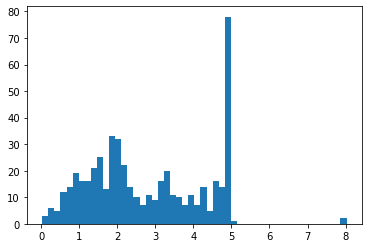

In [9]:
# plotting ages to determine decent value of total analysis time
plt.hist(c['age'].array, bins=50)

In [10]:
# From the graph we see that we can get a good amount of cryptos that are "older" than 4 years, take these
years = 4
crypstoclean = c[c['age'] > years]['Symbol'].reset_index(drop=True)

In [12]:
# turn dictionary into a DataFrame
# use entire analysis time to determine which we symbols we will use
crypstocleandata = pd.DataFrame.from_dict(analysisdata(crypstoclean, '091718', today, '1wk'))

In [13]:
# array of which cryptos to drop from data (mean has to be greater than 1.01 or less than .98 
# over the entire time to not be considered stable coin)
drop = (crypstocleandata.mean()<.98).array + (crypstocleandata.mean()>1.01).array
crypstocleandata.head()

BTC-USD     ETH-USD  USDT-USD   BNB-USD   XRP-USD   ADA-USD  \
2018-09-17  6710.629883  244.330002  0.999512  10.28060  0.570689  0.089754   
2018-09-24  6625.560059  232.848007  1.000360  10.01780  0.581572  0.085195   
2018-10-01  6602.950195  226.119003  0.996617  10.51900  0.482039  0.084658   
2018-10-08  6290.930176  195.714996  0.989570   9.49674  0.403286  0.071293   
2018-10-15  6482.350098  205.141998  0.983548   9.74330  0.456694  0.075873   

            DOGE-USD   TRX-USD   ETC-USD    LTC-USD  ...   RFR-USD   UPP-USD  \
2018-09-17  0.005901  0.023791  11.59860  61.366402  ...  0.004136  0.027492   
2018-09-24  0.005906  0.022165  11.33200  61.141899  ...  0.004403  0.026501   
2018-10-01  0.005562  0.026875  10.89810  58.160301  ...  0.004507  0.026545   
2018-10-08  0.005158  0.023622   9.40812  52.187401  ...  0.004916  0.028331   
2018-10-15  0.004517  0.024196   9.64013  52.915798  ...  0.005640  0.027628   

            BCD-USD  PIVX-USD  ELA-USD   SBD-USD   PRE-USD  MONA-USD  \
2018-09-17  2.06767  0.977504  7.35875  1.025670  0.095707   1.37821   
2018-09-24  1.94940  1.111900  7.13009  1.011630  0.080757   1.33755   
2018-10-01  1.95133  1.073080  7.94287  0.983768  0.055097   1.15220   
2018-10-08  1.70589  1.111680  8.10389  1.015540  0.056346   1.15861   
2018-10-15  1.72449  1.305840  8.90458  1.001930  0.062904   1.15259   

             BLZ-USD   GRS-USD  
2018-09-17  0.128594  0.578899  
2018-09-24  0.128123  0.559743  
2018-10-01  0.131439  0.550885  
2018-10-08  0.119386  0.540607  
2018-10-15  0.131991  0.544585  

[5 rows x 138 columns]

In [16]:
# final list with cryptos for analysis
cryptos = list(crypstocleandata.loc[:, drop ].columns)
cryptos

['BTC-USD',
 'ETH-USD',
 'BNB-USD',
 'XRP-USD',
 'ADA-USD',
 'DOGE-USD',
 'TRX-USD',
 'ETC-USD',
 'LTC-USD',
 'LINK-USD',
 'XLM-USD',
 'XMR-USD',
 'BCH-USD',
 'VET-USD',
 'FIL-USD',
 'XTZ-USD',
 'MANA-USD',
 'QNT-USD',
 'EOS-USD',
 'THETA-USD',
 'KCS-USD',
 'ZEC-USD',
 'MIOTA-USD',
 'HT-USD',
 'MKR-USD',
 'NEO-USD',
 'SNX-USD',
 'NEXO-USD',
 'ENJ-USD',
 'BAT-USD',
 'DASH-USD',
 'WAVES-USD',
 'ZIL-USD',
 'RVN-USD',
 'LRC-USD',
 'CEL-USD',
 'BTG-USD',
 'XEM-USD',
 'DCR-USD',
 'HOT1-USD',
 'XDC-USD',
 'GNO-USD',
 'QTUM-USD',
 'IOTX-USD',
 'GLM-USD',
 'FLUX-USD',
 'RPL-USD',
 'OMG-USD',
 'ZRX-USD',
 'IOST-USD',
 'ICX-USD',
 'ONT-USD',
 'STORJ-USD',
 'WAXP-USD',
 'SC-USD',
 'POLY-USD',
 'VGX-USD',
 'ZEN-USD',
 'ERG-USD',
 'CHSB-USD',
 'DGB-USD',
 'CVC-USD',
 'MED-USD',
 'LSK-USD',
 'EURS-USD',
 'CEEK-USD',
 'SYS-USD',
 'REN-USD',
 'SNT-USD',
 'MAID-USD',
 'ONG1-USD',
 'XNO-USD',
 'MVL-USD',
 'REQ-USD',
 'RLC-USD',
 'ARDR-USD',
 'DENT-USD',
 'POWR-USD',
 'UQC-USD',
 'XYO-USD',
 'NMR-USD',
 '

In [5]:
with open('cryptos', 'rb') as f:
    cryptos = pickle.load(f)

# Get all R matrices (data) for Cryptos from Yahoo Finance

After determining our 146 assests, we get 4 years worth of data for each of them from Yahoo Finance. The return data is taken from 09/18/2018 to 09/18/2022. We compute daily log returns for each asset. To generate many correlation frames we break up our log return data in 20 day intervals, each log return matrix will have a 5 day overlap. This generates 288 log return matrices.

The choice of 20 days is to attempt to avoid non-stationarity and to mimic a similar amount of days the stock market is open for trading in a month (even though cryptocurrencies can be traded 24/7). The choice of 5 day overlap is somewhat arbitrary as this is the time window which we can predict in the future, but the results should be independant of this choice (so long as there's an overlap) and so the results should hold for next day predictions.

In [10]:
def returndata(startdate, enddate, cryptosymbols):
    tempdict = analysisdata(cryptosymbols, startdate,  enddate, tinterval= '1d')
    tempdf = pd.DataFrame.from_dict(tempdict)
    tempdftwo = np.log(tempdf).diff()
    r = tempdftwo.drop(index=tempdftwo.index[0])
    return r

In [18]:
def rmatrices(returndata, epoch, shift_days):
    matrices = list()
    timeperiod = (returndata.index[len(returndata)-1] - returndata.index[0]).days
    n = int((timeperiod-epoch)/shift_days)
    print(f'{n} matrices expected')
    for i in range(n):
        matrix = returndata.iloc[i*shift_days:epoch+(i*shift_days)]
        matrices.append(matrix)
    return matrices

In [16]:
with open('fullreturndata', 'rb') as f:
    fulldata = pickle.load(f)

In [71]:
fulldata.head()

BTC-USD   ETH-USD   BNB-USD   XRP-USD   ADA-USD  DOGE-USD  \
2018-09-18  0.014242  0.059353  0.014650  0.167392  0.083015 -0.042873   
2018-09-19  0.004266 -0.000029  0.007831  0.012943  0.041196 -0.064215   
2018-09-20  0.018754  0.067321  0.046258  0.322005  0.119002  0.015216   
2018-09-21  0.032487  0.093422  0.032836  0.221479  0.072332 -0.001933   
2018-09-22 -0.001928 -0.025066 -0.016054  0.016491 -0.051686  0.012935   

             TRX-USD   ETC-USD   LTC-USD  LINK-USD  ...   RFR-USD   UPP-USD  \
2018-09-18  0.046017  0.024250  0.029198  0.080378  ...  0.027385  0.072964   
2018-09-19  0.018599  0.017946  0.004377  0.122532  ... -0.004947 -0.053685   
2018-09-20  0.080693  0.034757  0.041457  0.085075  ...  0.028562  0.071362   
2018-09-21  0.152074  0.043384  0.069703 -0.014332  ...  0.037101  0.044086   
2018-09-22 -0.072955 -0.021925 -0.004724 -0.044694  ... -0.036594 -0.062511   

             BCD-USD  PIVX-USD   ELA-USD   SBD-USD   PRE-USD  MONA-USD  \
2018-09-18  0.014787  0.039540 -0.004037  0.035525  0.006427  0.011794   
2018-09-19 -0.021323  0.024402 -0.037177 -0.006390 -0.000809 -0.061376   
2018-09-20  0.033825  0.044726 -0.024209  0.013509  0.005258  0.030848   
2018-09-21  0.027176  0.073492  0.064079  0.026679  0.041873  0.514862   
2018-09-22 -0.037818 -0.020632 -0.056305 -0.016459 -0.026178 -0.165792   

             BLZ-USD   GRS-USD  
2018-09-18  0.124479  0.057524  
2018-09-19 -0.042424 -0.003957  
2018-09-20  0.029403  0.072196  
2018-09-21  0.143929  0.027033  
2018-09-22 -0.038725 -0.060207  

[5 rows x 134 columns]

In [19]:
rmatrixlist = rmatrices(fulldata, 20, 5)

288 matrices expected


The steps to identify the correct number of market states are as follows:
1) Compute all correlation frames for each log return matrix. \
2) Compute a similarity matrix using all the correlation frames.\
3) Perform a multi-dimensional scaling (MDS) of our similarity matrix in order to better perform a k-means clustering.\
4) Do a k-means clustering, the optimal number of k is the number of market states. 

There are some caveats to some steps. For the first step; because each correlation frame is made up of 146 assests over 20 days, this will inherently be a noisey time series. As such, we perform a noise supression technique known as "power mapping". This consists of taking every matrix element in every correlation frame to sign(C_ij)|C_ij|^(1+e). This supresses noise and will allow us to be more confident in our selection of optimal k in the k-means clustering. \
For the k-means clustering optimization; instead of the elbow method (which can be somewhat arbitrary) we look at the results of 500 runs of a k-means clustering for k = [1,2,3,4,5,6,7,8,9], each for a noise supression value (e) of e=[0,.1,.2,.3,.4,.5,.6,.7]. From the 500 runs, we compute the average intracluster distance from every point to it's centroid. We also compute the standard deviation of these distances. For a given value of e, the correct k value for the k-means clustering will be the k which has the local minima in a graph of the standard deviations. \
Furthermore, we should see that the truly correct k should be robust to the actual noise supression parameter we use. Once the optimal k has been identify, we use the value of e which gives the smallest standard deviation for the optimal k. \
We determine, for 5 day sliding window, the correct number of market states is 4 with the lowest std given by e = 0.3.

## Determining Correct Number of K-Clusters and Noise Supression

In [12]:
# function which does power mapping for noise supresion, takes corr matrices and replaces each element by
# sign(C_ij)|C_ij|^(1+e)
def noisesupression(corrmatrices, e):
    noisesup = list()
    for df in corrmatrices:
        temp = df.copy(deep=True) #need this or else we actually change the original corrmatrices inplace
        for i,j in itertools.product(range(len(df.index)), range(len(df.columns))):
            temp.iloc[i,j] = math.copysign(1,temp.iloc[i,j])* abs((temp.iloc[i,j]))**(1+e)
        noisesup.append(temp)
    return noisesup


In [13]:
# Function to get similarity matrix from noise supressed correlation matrices
def getsimmatrix(supcorrmatrices):
    emptymat= np.ndarray(shape=(len(supcorrmatrices),len(supcorrmatrices)), dtype=float)
    print("matrix shape:",emptymat.shape)
    for i, j in itertools.product(range(len(supcorrmatrices)), range(len(supcorrmatrices))):
        emptymat[i,j] = abs(supcorrmatrices[i] - supcorrmatrices[j]).mean().mean()
    return emptymat

In [14]:
# function to get the average (of averages) of intra-cluster distances for a similarity matrix that has 
# been transformed by MDS for 1 run of k-means clustering
def intraclusterdist(simtrans, kclusters):
    emptydict = {}
    avgstd = {}
    totals = []
    km = KMeans(n_clusters = kclusters, init ='random')
    y_km = km.fit_predict(simtrans)
    # make dictionary with cluster as key and all distances from points to cluster centroid as values (array)
    for i in range(len(simtrans)):
        emptydict.setdefault(y_km[i], []).append(math.sqrt(sum((simtrans[i] - km.cluster_centers_[y_km[i]])**2)))
    # take the dictionary from above and get a new dictionary with cluster as key
    # and a value of [# of points in cluster, average distance]
    for key in emptydict:
        avg = sum(emptydict[key])/len(emptydict[key])
        avgstd.setdefault(key,[]).append(len(emptydict[key]))
        avgstd.setdefault(key, []).append(avg)
    # now get weighted average (of average) intracluster distance and avg std (for unequal sample size)
    avgavgdis = 0 
    for key in avgstd:
        avgavgdis += (avgstd[key][0]*avgstd[key][1])/len(simtrans)
    return avgavgdis
        

In [8]:
# Function to do 500 runs of kmeans cluster for a given choice of k and a similarity matrix
# Given that no random_state seed is fed to the KMeans algo, we will have different random intial conditions
# for centroid initialization of our 500 runs
# This will get the total average distance and std of intracluster distance over 500 runs
def multikrun(simtrans, nruns, kclusters):
    avgs = []
    std = [] 
    for i in range(nruns):
        emp = intraclusterdist(simtrans, kclusters)
        avgs.append(emp)
    totalaveragedis = sum(avgs)/nruns
    for val in avgs:
        std.append((val - totalaveragedis)**2)
    totalaveragestd = math.sqrt(sum(std)/nruns)
    return totalaveragedis, totalaveragestd
        

In [9]:
# function that gives a list of the avg intracluster dist and std for all values of k from 1 to highestk
# will use this to plot
def getkruns(simtrans, highestk):
    dlist = []
    stdlist = []
    for i in range(1,highestk+1):
        temp = multikrun(simtrans, nruns=500, kclusters = i)
        dlist.append(temp[0])
        stdlist.append(temp[1])
    return dlist , stdlist

In [10]:
# function that shows STD ratios from consecutive k values (to discern correct number of states)
def showstdratios(resultsfrommultik):
    for i in range(len(resultsfrommultik[1])-1):
        print("k =", i+2,"divded by k=", i+1)
        try:
            ratio = (resultsfrommultik[1][i+1]/resultsfrommultik[1][i])*100
            print((resultsfrommultik[1][i+1]/resultsfrommultik[1][i])*100)
        except:
            print('divison by zero here k=', i+1, 'has std', resultsfrommultik[1][i] )

In [30]:
# function that puts everything together
def ultimate(rmatrix, epsilon):
    start_time = time.time()
    # initialize a list that will have length of epsilon, each entry should be a list of two elements, one of avg
    # distance per k value and one of std of avg dist for that k value
    hold = []
    # initialize your un-noise supressed correlation matrices
    corrmatrix = [i.corr(method='pearson') for i in rmatrix]
    # for each noise supression parameter
    for ep in epsilon:
        print('Noise supression is', ep)
        # noise supress correlation frames
        supcorrmatrix = noisesupression(corrmatrix, ep)
        # then get similarity matrix
        simmatrix = getsimmatrix(supcorrmatrix)
        # then do MDS on it
        mds = MDS(n_components = 3, dissimilarity = 'precomputed')
        simtrans = mds.fit_transform(simmatrix)
        # then do 500 runs of k means for k={1,10}, this is [list of avg distance per k], [list of std dist per k]
        result = getkruns(simtrans, 10)
        # add results to list so we can check back on them later
        hold.append(result)
        # discern best k from result
        print(result[1])
        showstdratios(result)
        # plot <D> vs k
        ax5 =plt.gca()
        ax5.set_ylim([0.02, .22])
        ax5.set_xlim([1, 10])
        plt.errorbar(np.arange(1,11), result[0], result[1], linestyle='--',elinewidth=8, barsabove=True)
        plt.title('\u03B5 = %1.1f' %ep )
        plt.ylabel('Average Intracluster Distance')
        plt.xlabel('Number of clusters (k)')
        plt.locator_params(nbins=11)
        plt.show()
    print("This took %s seconds " % (time.time() - start_time))
    return hold

THIS IS FOR 2 DAY WINDOW 

Noise supression is 0.0
matrix shape: (720, 720)
[2.525757381022231e-15, 2.5232348791663546e-06, 0.00020861881616471192, 7.327475480915618e-05, 0.00016273962612758886, 0.00023588552602496653, 0.00029982110841205296, 0.00032731731526276054, 0.0003719474597217105, 0.00026706352855722896]
k = 2 divded by k= 1
99900128893.0271
k = 3 divded by k= 2
8267.91108062191
k = 4 divded by k= 3
35.12375161371023
k = 5 divded by k= 4
222.09508111141906
k = 6 divded by k= 5
144.94658224176504
k = 7 divded by k= 6
127.10449575457181
k = 8 divded by k= 7
109.17087092244311
k = 9 divded by k= 8
113.63513091970773
k = 10 divded by k= 9
71.80141215564284


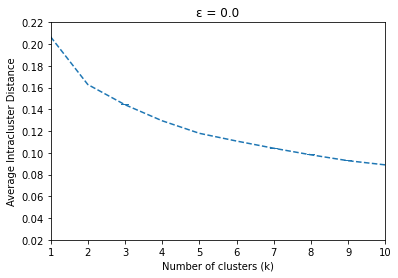

Noise supression is 0.1
matrix shape: (720, 720)
[7.771561172376096e-16, 4.480946498536042e-06, 0.00010020018843589418, 1.508697723913148e-05, 3.8568285286465955e-06, 0.00032437113797247855, 0.00036512062164141676, 0.00022691286144524837, 0.00022597649727292273, 0.00028512587333157796]
k = 2 divded by k= 1
576582542316.4014
k = 3 divded by k= 2
2236.138915486501
k = 4 divded by k= 3
15.056835196256928
k = 5 divded by k= 4
25.56395802495837
k = 6 divded by k= 5
8410.30747317937
k = 7 divded by k= 6
112.56261081785755
k = 8 divded by k= 7
62.14736938854646
k = 9 divded by k= 8
99.58734636443181
k = 10 divded by k= 9
126.17501234529611


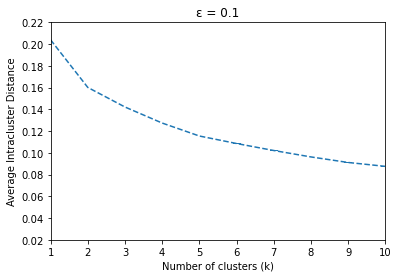

Noise supression is 0.2
matrix shape: (720, 720)
[8.326672684688674e-16, 4.3369785736170936e-07, 8.167483960425504e-05, 4.0198011197196765e-05, 8.465604306365834e-05, 0.0004071765279557016, 0.0003320689893859413, 0.00034049290232487613, 0.00025185488444331316, 0.00038906912191924507]
k = 2 divded by k= 1
52085373568.14871
k = 3 divded by k= 2
18832.198088573263
k = 4 divded by k= 3
49.21712903505055
k = 5 divded by k= 4
210.59759063294626
k = 6 divded by k= 5
480.97750995699073
k = 7 divded by k= 6
81.5540598700887
k = 8 divded by k= 7
102.53679602979857
k = 9 divded by k= 8
73.96773404780393
k = 10 divded by k= 9
154.48146768295683


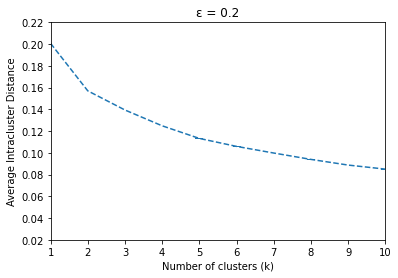

Noise supression is 0.30000000000000004
matrix shape: (720, 720)
[2.498001805406602e-16, 7.37710835202525e-07, 9.909028156285075e-05, 1.4124151340173983e-05, 1.5333135859220447e-05, 0.0002562842678213163, 0.00030137539025378837, 0.0002597821780986061, 0.00032472315571559457, 0.0003077962277682633]
k = 2 divded by k= 1
295320377113.35724
k = 3 divded by k= 2
13432.130427587841
k = 4 divded by k= 3
14.253820977605509
k = 5 divded by k= 4
108.5596967203806
k = 6 divded by k= 5
1671.4406640256957
k = 7 divded by k= 6
117.59418274706974
k = 8 divded by k= 7
86.1988690847794
k = 9 divded by k= 8
124.99824202426184
k = 10 divded by k= 9
94.7872741289332


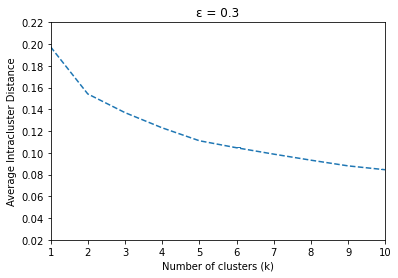

Noise supression is 0.4
matrix shape: (720, 720)
[2.7755575615628914e-16, 4.5158486897846e-07, 0.00017686391933050387, 7.232662896569746e-05, 2.487819709077683e-05, 0.00034730324296257137, 0.0003361971257041794, 0.00021827639015129785, 0.00026780268262981247, 0.0003431208872240761]
k = 2 divded by k= 1
162700595812.60373
k = 3 divded by k= 2
39165.15620432358
k = 4 divded by k= 3
40.89394221245397
k = 5 divded by k= 4
34.397009022189984
k = 6 divded by k= 5
1396.0145170299666
k = 7 divded by k= 6
96.80218440701724
k = 8 divded by k= 7
64.92512084810616
k = 9 divded by k= 8
122.68971575175198
k = 10 divded by k= 9
128.1245146070389


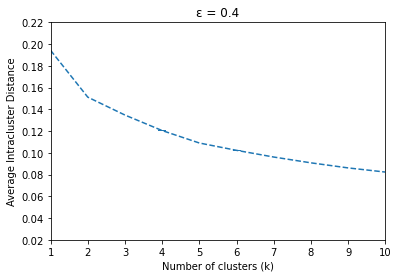

Noise supression is 0.5
matrix shape: (720, 720)
[7.771561172376096e-16, 5.414068336604272e-07, 0.0003366076784383341, 3.747079008153968e-05, 1.63056100816882e-05, 0.0002720268749914373, 0.00028551794212878715, 0.0002918801852784286, 0.00026536541380743097, 0.00033350195022840474]
k = 2 divded by k= 1
69665131837.96971
k = 3 divded by k= 2
62172.77978605198
k = 4 divded by k= 3
11.131888094586131
k = 5 divded by k= 4
43.51552248085984
k = 6 divded by k= 5
1668.302342743578
k = 7 divded by k= 6
104.95946113330696
k = 8 divded by k= 7
102.22831640708998
k = 9 divded by k= 8
90.91587137177372
k = 10 divded by k= 9
125.67649470342008


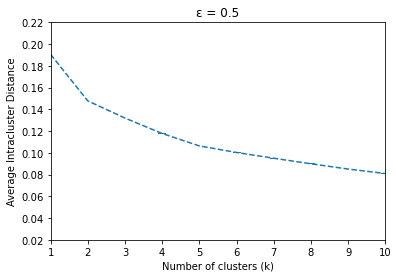

Noise supression is 0.6000000000000001
matrix shape: (720, 720)
[2.248201624865942e-15, 1.9185488033218565e-06, 0.00013272033189401164, 4.744748876336629e-05, 6.0334123280091134e-05, 0.00044217911514234055, 0.0005937881449809841, 0.00038790048276772873, 0.00022326634326664838, 0.0001889021543529337]
k = 2 divded by k= 1
85337043710.93753
k = 3 divded by k= 2
6917.745937148644
k = 4 divded by k= 3
35.74997747990648
k = 5 divded by k= 4
127.15978200868344
k = 6 divded by k= 5
732.8839653301955
k = 7 divded by k= 6
134.28679117733535
k = 8 divded by k= 7
65.32641078244349
k = 9 divded by k= 8
57.55763480200107
k = 10 divded by k= 9
84.60843295459301


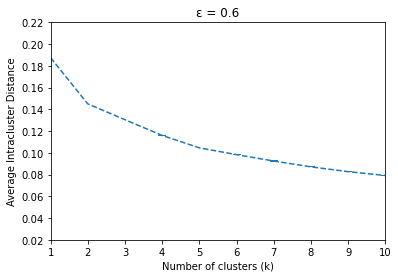

Noise supression is 0.7000000000000001
matrix shape: (720, 720)
[5.551115123125783e-16, 9.888775075425742e-06, 0.0004711628262674965, 1.4956837917612622e-05, 0.00010636192198371783, 0.0003531740770101441, 0.00021646556168207013, 0.0002886402391995001, 0.0003278166520871818, 0.0004080719577048061]
k = 2 divded by k= 1
1781403349793.5208
k = 3 divded by k= 2
4764.622743198672
k = 4 divded by k= 3
3.174452033089952
k = 5 divded by k= 4
711.1257243649738
k = 6 divded by k= 5
332.0493560319537
k = 7 divded by k= 6
61.29146383409467
k = 8 divded by k= 7
133.34233720901767
k = 9 divded by k= 8
113.57274820597834
k = 10 divded by k= 9
124.48176598310224


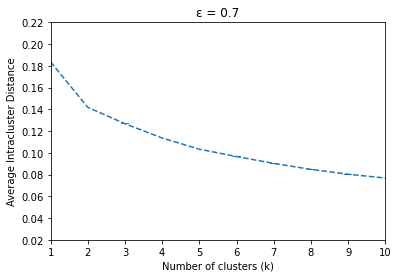

This took 13775.628486156464 seconds 


In [57]:
final = ultimate(rmatrices, np.arange(0,.8,.1))

This is for 5 day window

Noise supression is 0.0
matrix shape: (288, 288)
[2.3869795029440866e-15, 1.3322676295501878e-15, 0.0002422258813421857, 0.0001628919775981228, 0.00031614183206943314, 0.0005050347852080629, 0.0004098146435570953, 0.0004187211917798885, 0.0005143612083990598, 0.0005822077381044616]
k = 2 divded by k= 1
55.81395348837209
k = 3 divded by k= 2
18181473149202.625
k = 4 divded by k= 3
67.24796569859927
k = 5 divded by k= 4
194.08066421134566
k = 6 divded by k= 5
159.7494333167348
k = 7 divded by k= 6
81.14582511148434
k = 8 divded by k= 7
102.17331136473955
k = 9 divded by k= 8
122.84097831605499
k = 10 divded by k= 9
113.19044449649944


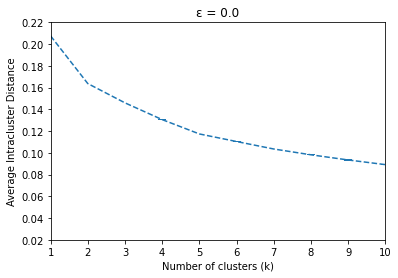

Noise supression is 0.1
matrix shape: (288, 288)
[2.220446049250313e-15, 2.7755575615628914e-17, 0.00013814693123870438, 4.172408062477106e-05, 5.822990888846858e-05, 0.00024667282701135336, 0.0005654261985654285, 0.0004071147033476791, 0.0006015348882744284, 0.0004916022590246139]
k = 2 divded by k= 1
1.25
k = 3 divded by k= 2
497726774439205.25
k = 4 divded by k= 3
30.20268365764559
k = 5 divded by k= 4
139.55947744453886
k = 6 divded by k= 5
423.61877550559353
k = 7 divded by k= 6
229.22111260329626
k = 8 divded by k= 7
72.0013866319938
k = 9 divded by k= 8
147.7556284084176
k = 10 divded by k= 9
81.72464616887495


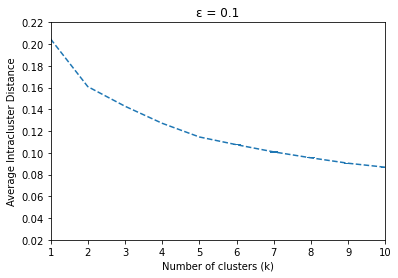

Noise supression is 0.2
matrix shape: (288, 288)
[1.887379141862766e-15, 1.6504266659623503e-06, 0.00015757088925389215, 9.101579606313686e-05, 7.90457358596591e-05, 0.00026302705126682855, 0.00041345473601532904, 0.0005399554766089866, 0.0005721001596677011, 0.0005061326454946781]
k = 2 divded by k= 1
87445422562.71025
k = 3 divded by k= 2
9547.282075814854
k = 4 divded by k= 3
57.76180898267583
k = 5 divded by k= 4
86.848370589239
k = 6 divded by k= 5
332.75299218393906
k = 7 divded by k= 6
157.1909558442712
k = 8 divded by k= 7
130.5960313365397
k = 9 divded by k= 8
105.95320993141671
k = 10 divded by k= 9
88.4692368882855


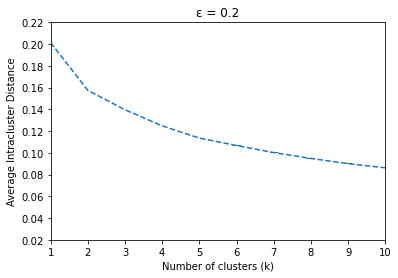

Noise supression is 0.30000000000000004
matrix shape: (288, 288)
[2.192690473634684e-15, 5.551115123125783e-16, 0.0001382526751481598, 9.519556538095051e-06, 0.00015771029298791188, 0.0002498884725537467, 0.00035057779004822674, 0.00036406212926017793, 0.0004918811990767858, 0.00043535552985020165]
k = 2 divded by k= 1
25.31645569620253
k = 3 divded by k= 2
24905387851209.066
k = 4 divded by k= 3
6.8856219439467115
k = 5 divded by k= 4
1656.6978971845167
k = 6 divded by k= 5
158.44778918323362
k = 7 divded by k= 6
140.29370241271272
k = 8 divded by k= 7
103.84631873288272
k = 9 divded by k= 8
135.1091364752365
k = 10 divded by k= 9
88.50826798570927


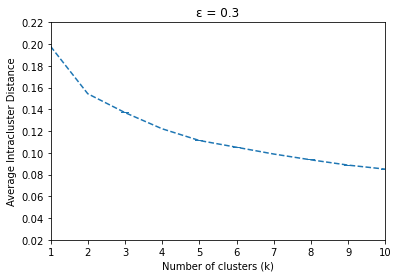

Noise supression is 0.4
matrix shape: (288, 288)
[2.1649348980190553e-15, 8.326672684688674e-16, 0.0001724320349079215, 0.0001149291673938706, 0.00015630032483873526, 0.0004203973446634756, 0.00038973967267322653, 0.0003943007589267695, 0.0004591622116719306, 0.0004712275467531204]
k = 2 divded by k= 1
38.46153846153847
k = 3 divded by k= 2
20708395950881.38
k = 4 divded by k= 3
66.65186515675154
k = 5 divded by k= 4
135.99709141116693
k = 6 divded by k= 5
268.9676717545057
k = 7 divded by k= 6
92.70745346529478
k = 8 divded by k= 7
101.17029047165214
k = 9 divded by k= 8
116.44974078206309
k = 10 divded by k= 9
102.62768467754711


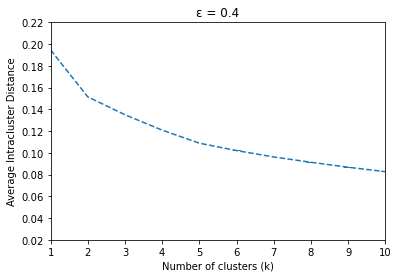

Noise supression is 0.5
matrix shape: (288, 288)
[6.38378239159465e-16, 1.1102230246251565e-15, 0.0002598813120492711, 0.00010750106282230279, 0.00015585779753967568, 0.00041489061565446014, 0.0004721559350893471, 0.0005448736771258747, 0.0006116135147195573, 0.0005767824865142218]
k = 2 divded by k= 1
173.91304347826087
k = 3 divded by k= 2
23408027602113.055
k = 4 divded by k= 3
41.36544562385524
k = 5 divded by k= 4
144.9825643094391
k = 6 divded by k= 5
266.19817693038055
k = 7 divded by k= 6
113.80251017356828
k = 8 divded by k= 7
115.40121316546981
k = 9 divded by k= 8
112.24868082189712
k = 10 divded by k= 9
94.3050590990772


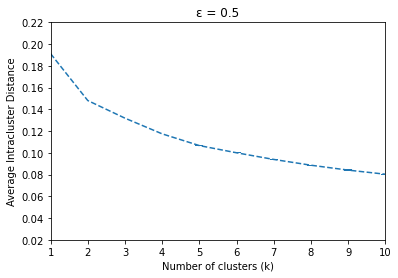

Noise supression is 0.6000000000000001
matrix shape: (288, 288)
[1.582067810090848e-15, 3.956404946609752e-06, 0.0003396571030451098, 0.00012260020128860996, 0.00016683067334074826, 0.0004721631816981095, 0.0004389524305059531, 0.00047897932461576903, 0.0005571097305878711, 0.0004848349614044756]
k = 2 divded by k= 1
250078089028.4697
k = 3 divded by k= 2
8584.993387397373
k = 4 divded by k= 3
36.09528556578646
k = 5 divded by k= 4
136.0769979064035
k = 6 divded by k= 5
283.0194065894141
k = 7 divded by k= 6
92.9662556337587
k = 8 divded by k= 7
109.1187316274065
k = 9 divded by k= 8
116.3118535512524
k = 10 divded by k= 9
87.02683417373987


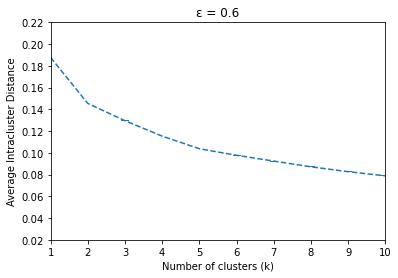

Noise supression is 0.7000000000000001
matrix shape: (288, 288)
[1.7486012637846216e-15, 2.7755575615628914e-17, 0.00012831053705991875, 0.00018165029639562592, 0.00012567593301141003, 0.0002972712336457584, 0.00033948348855135656, 0.0003392034642404915, 0.00033247594764498136, 0.00037089818955885807]
k = 2 divded by k= 1
1.5873015873015872
k = 3 divded by k= 2
462287429512606.6
k = 4 divded by k= 3
141.57083319727548
k = 5 divded by k= 4
69.18564709506097
k = 6 divded by k= 5
236.53791662622416
k = 7 divded by k= 6
114.19991244625444
k = 8 divded by k= 7
99.917514600766
k = 9 divded by k= 8
98.01667220275192
k = 10 divded by k= 9
111.55639744349388


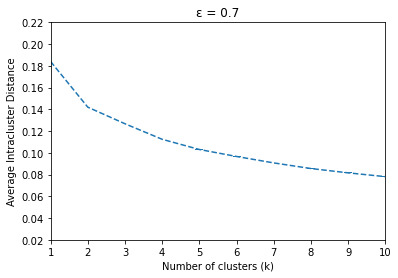

This took 6116.5562579631805 seconds 


In [31]:
final = ultimate(rmatrices, np.arange(0,.8,.1))

In [37]:
with open('fivedaywindowfinal', 'rb') as f:
    final = pickle.load(f)

In [38]:
final

[([0.20756113994950565,
   0.16371111825259244,
   0.14595842184675992,
   0.1305474679225885,
   0.11736261866148977,
   0.11039006230713568,
   0.10351254881436539,
   0.09817285525817128,
   0.09342777558099227,
   0.08914507462135353],
  [2.3869795029440866e-15,
   1.3322676295501878e-15,
   0.0002422258813421857,
   0.0001628919775981228,
   0.00031614183206943314,
   0.0005050347852080629,
   0.0004098146435570953,
   0.0004187211917798885,
   0.0005143612083990598,
   0.0005822077381044616]),
 ([0.20474641849057318,
   0.16089758823515862,
   0.14286225392780302,
   0.12716968370674456,
   0.11457602309733912,
   0.10745549520783904,
   0.10085150554416338,
   0.0953806410377876,
   0.09041299981067208,
   0.0867374424600678],
  [2.220446049250313e-15,
   2.7755575615628914e-17,
   0.00013814693123870438,
   4.172408062477106e-05,
   5.822990888846858e-05,
   0.00024667282701135336,
   0.0005654261985654285,
   0.0004071147033476791,
   0.0006015348882744284,
   0.00049160225902

ep0 k = 4 
ep1 k = 4
ep2 k = 5
ep3 k = 4
ep4 k = 4 
ep5 k = 4
ep6 k = 4
ep7 k = 5

Using the correct noise supression parameter and k parameter, we obtain the results for our correlation frames! We show examples of the correlation patterns that correspond to each market state!

# Getting All Data for ep = 0.3

In [47]:
# get averages of each R matrix and put them in a list
raverages = list()
for i in range(len(rmatrixlist)):
    raverages.append(rmatrixlist[i].mean().mean())
# Get a Correlation Matrix for each R matrix
corrmatrix = [i.corr(method='pearson') for i in rmatrixlist]
# Get average correlation for each matrix without noise supp 
corraverages = [i.mean().mean() for i in corrmatrix]
# get supressed noise matrices for ep = 0.3
supcorrmatrix = noisesupression(corrmatrix, 0.3)
# Get average correlation for each matrix with noise supp 
supcorraverages = [i.mean().mean() for i in supcorrmatrix]
# Get similarity matrix from supressed corr matrices
simmatrix = getsimmatrix(supcorrmatrix)
# initialize MDS algo and fit it with our similarity matrix
# simtrans gives the new points in a reduced dimension n_components set by the MDS parameters
mds = MDS(n_components = 3, dissimilarity = 'precomputed')
simtrans = mds.fit_transform(simmatrix)
# initialize K-Means clustering algorithm
# take the MDS reduced similarity matrix and use K-means clustering on it with k=5 as determined
km = KMeans(n_clusters=4, init='random')
y_km = km.fit_predict(simtrans)

matrix shape: (288, 288)


In [12]:
with open('fivedayravgs', 'rb') as f:
    ravgs = pickle.load(f)
with open('fivedayy_km', 'rb') as f:
    y_km = pickle.load(f)
with open('fivedaysupcorr', 'rb') as f:
    supcorrmatrix = pickle.load(f)

<IPython.core.display.Javascript object>


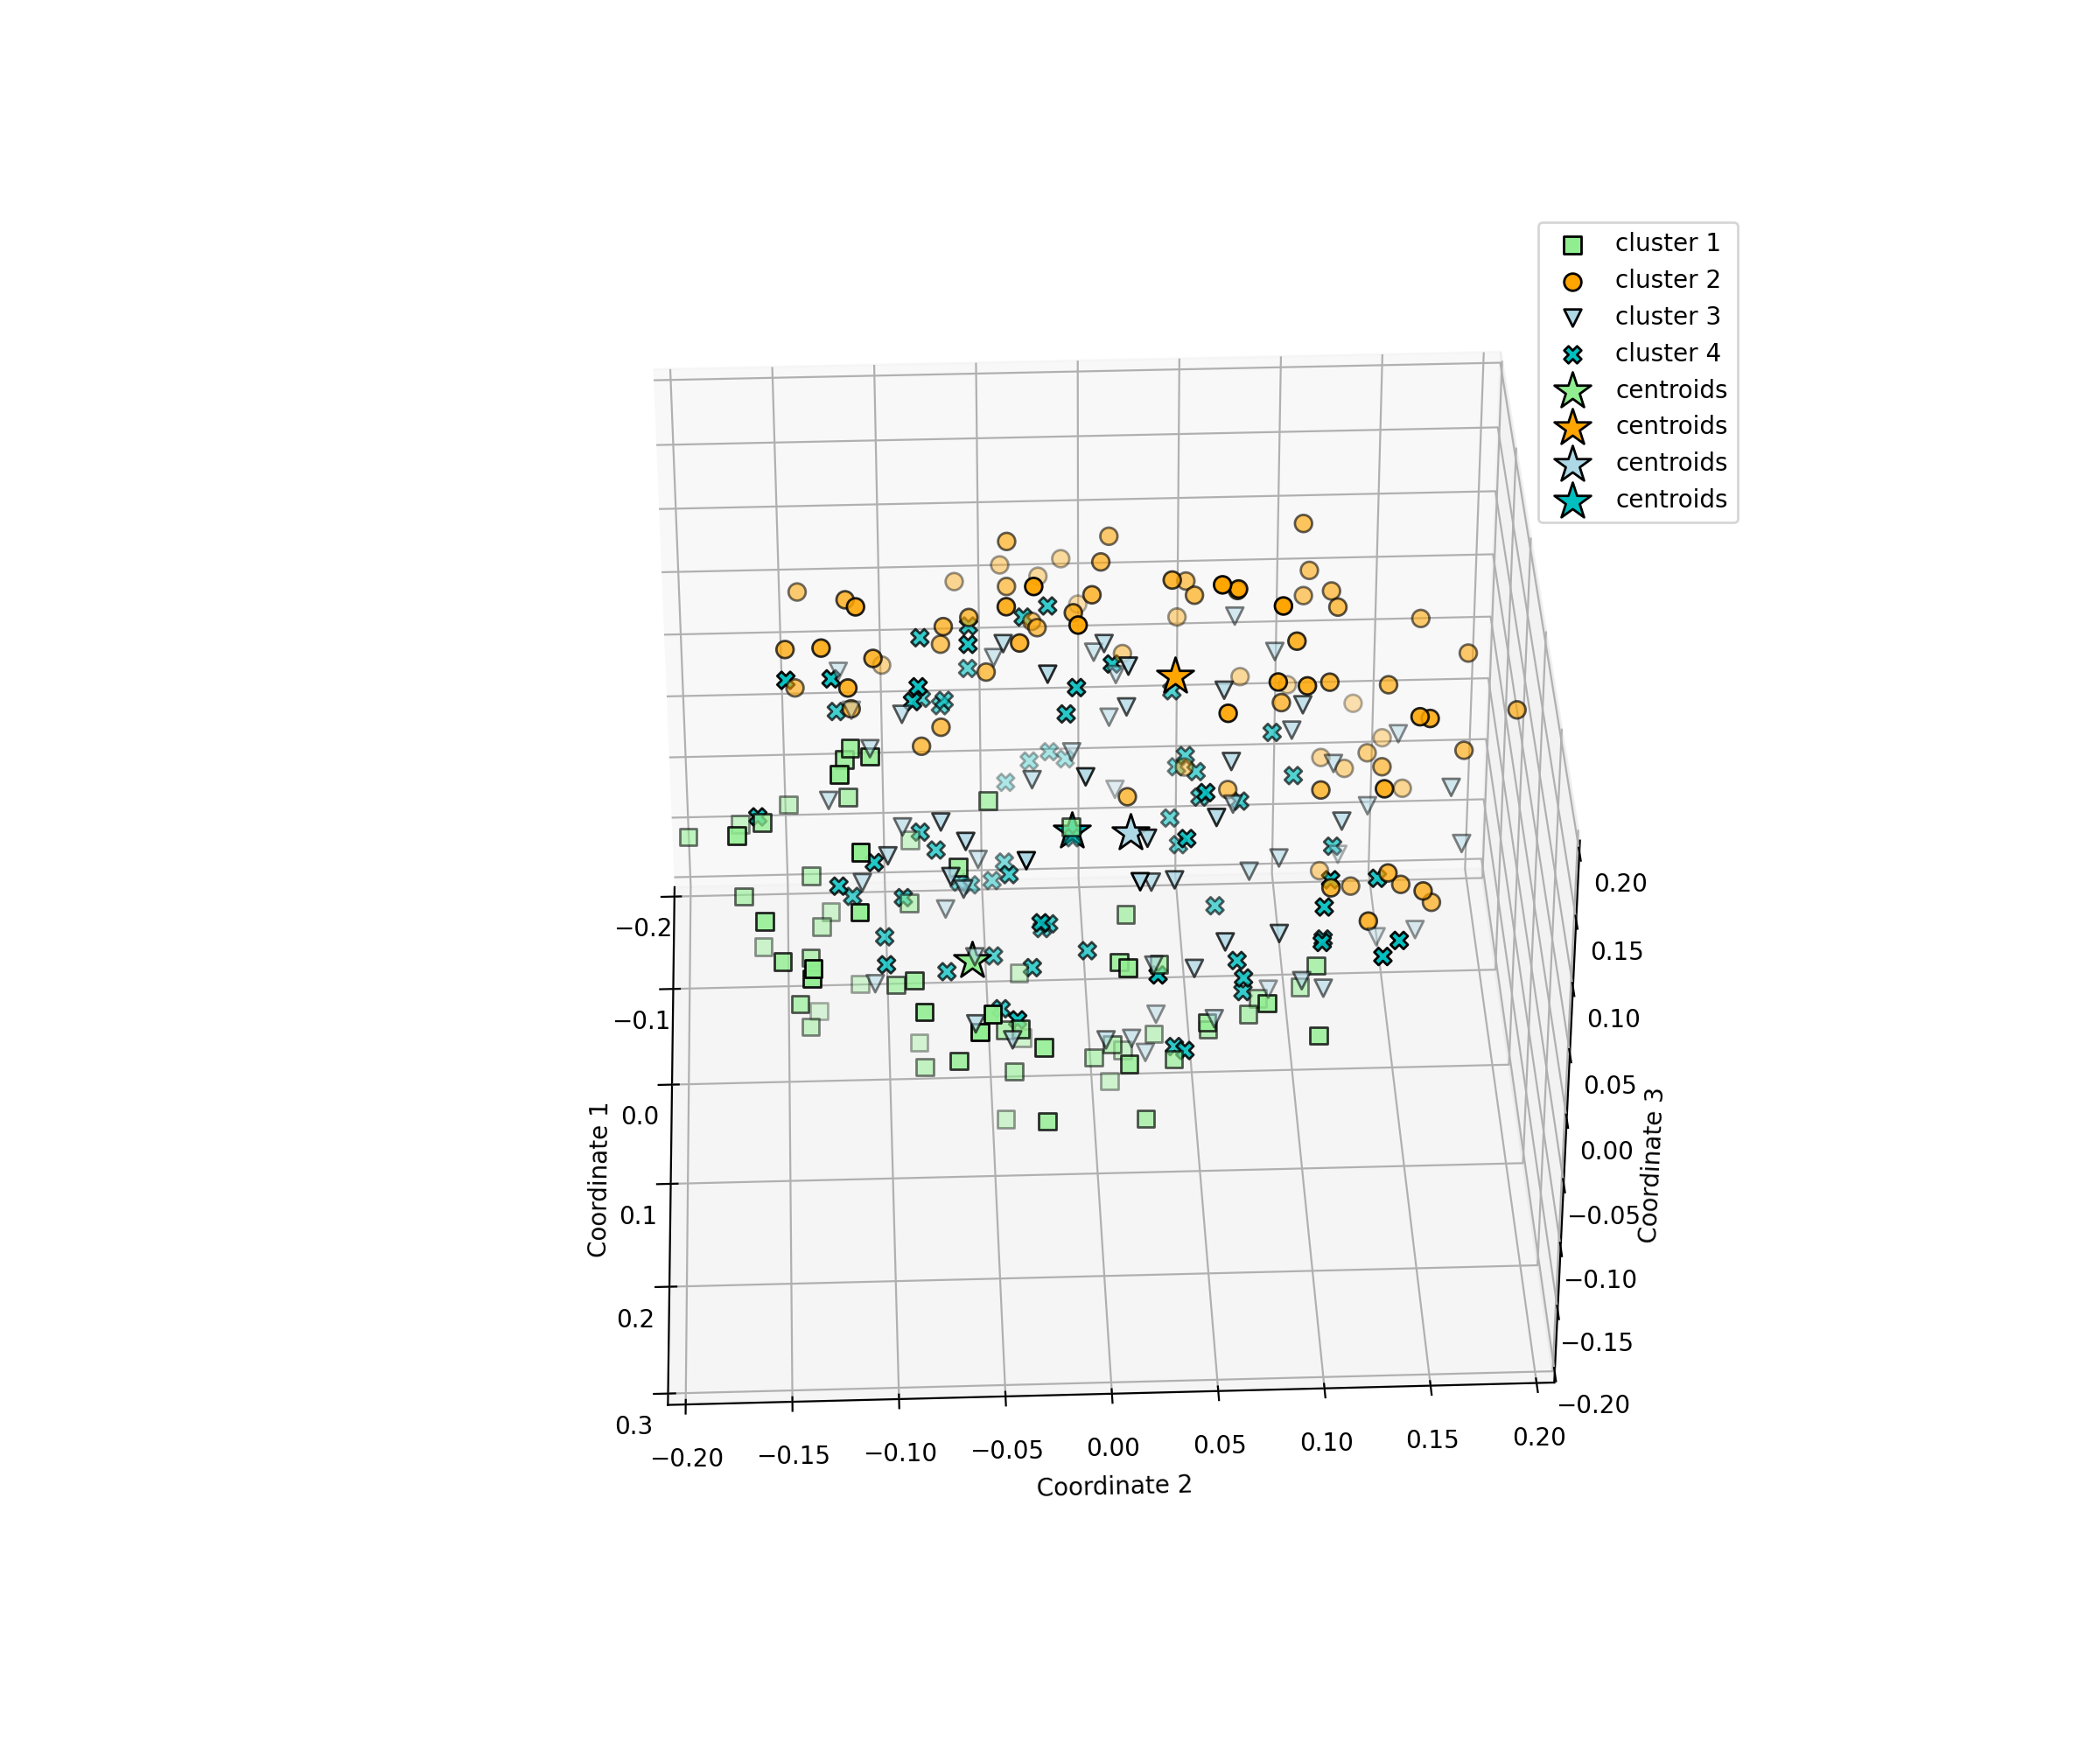

In [76]:
# plotting an example for these 3 points and doing a k=2 means clustering
%matplotlib notebook
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')


ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 2')
ax.set_zlabel('Coordinate 3')


ax.scatter(
    simtrans[y_km == 0, 0], simtrans[y_km == 0, 1], simtrans[y_km == 0, 2],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

ax.scatter(
    simtrans[y_km == 1, 0], simtrans[y_km == 1, 1], simtrans[y_km == 1, 2],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

ax.scatter(
    simtrans[y_km == 2, 0], simtrans[y_km == 2, 1], simtrans[y_km == 2, 2],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

ax.scatter(
    simtrans[y_km == 3, 0], simtrans[y_km == 3, 1], simtrans[y_km == 3, 2],
    s=50, c='c',
    marker='X', edgecolor='black',
    label='cluster 4'
)



# plot the centroids
ax.scatter(
    km.cluster_centers_[0, 0], km.cluster_centers_[0, 1], km.cluster_centers_[0, 2], 
    s=250, marker='*',
    c='lightgreen', edgecolor='black',
    label='centroids'
)
ax.scatter(
    km.cluster_centers_[1, 0], km.cluster_centers_[1, 1], km.cluster_centers_[1, 2], 
    s=250, marker='*',
    c='orange', edgecolor='black',
    label='centroids'
)
ax.scatter(
    km.cluster_centers_[2, 0], km.cluster_centers_[2, 1], km.cluster_centers_[2, 2], 
    s=250, marker='*',
    c='lightblue', edgecolor='black',
    label='centroids'
)
ax.scatter(
    km.cluster_centers_[3, 0], km.cluster_centers_[3, 1], km.cluster_centers_[3, 2], 
    s=250, marker='*',
    c='c', edgecolor='black',
    label='centroids'
)


plt.legend(scatterpoints=1)
ax.set_xlim([-.2, .3])
ax.set_ylim([-.2, .2])
ax.set_zlim([-.2, .2])
plt.grid()








plt.show()

<IPython.core.display.Javascript object>


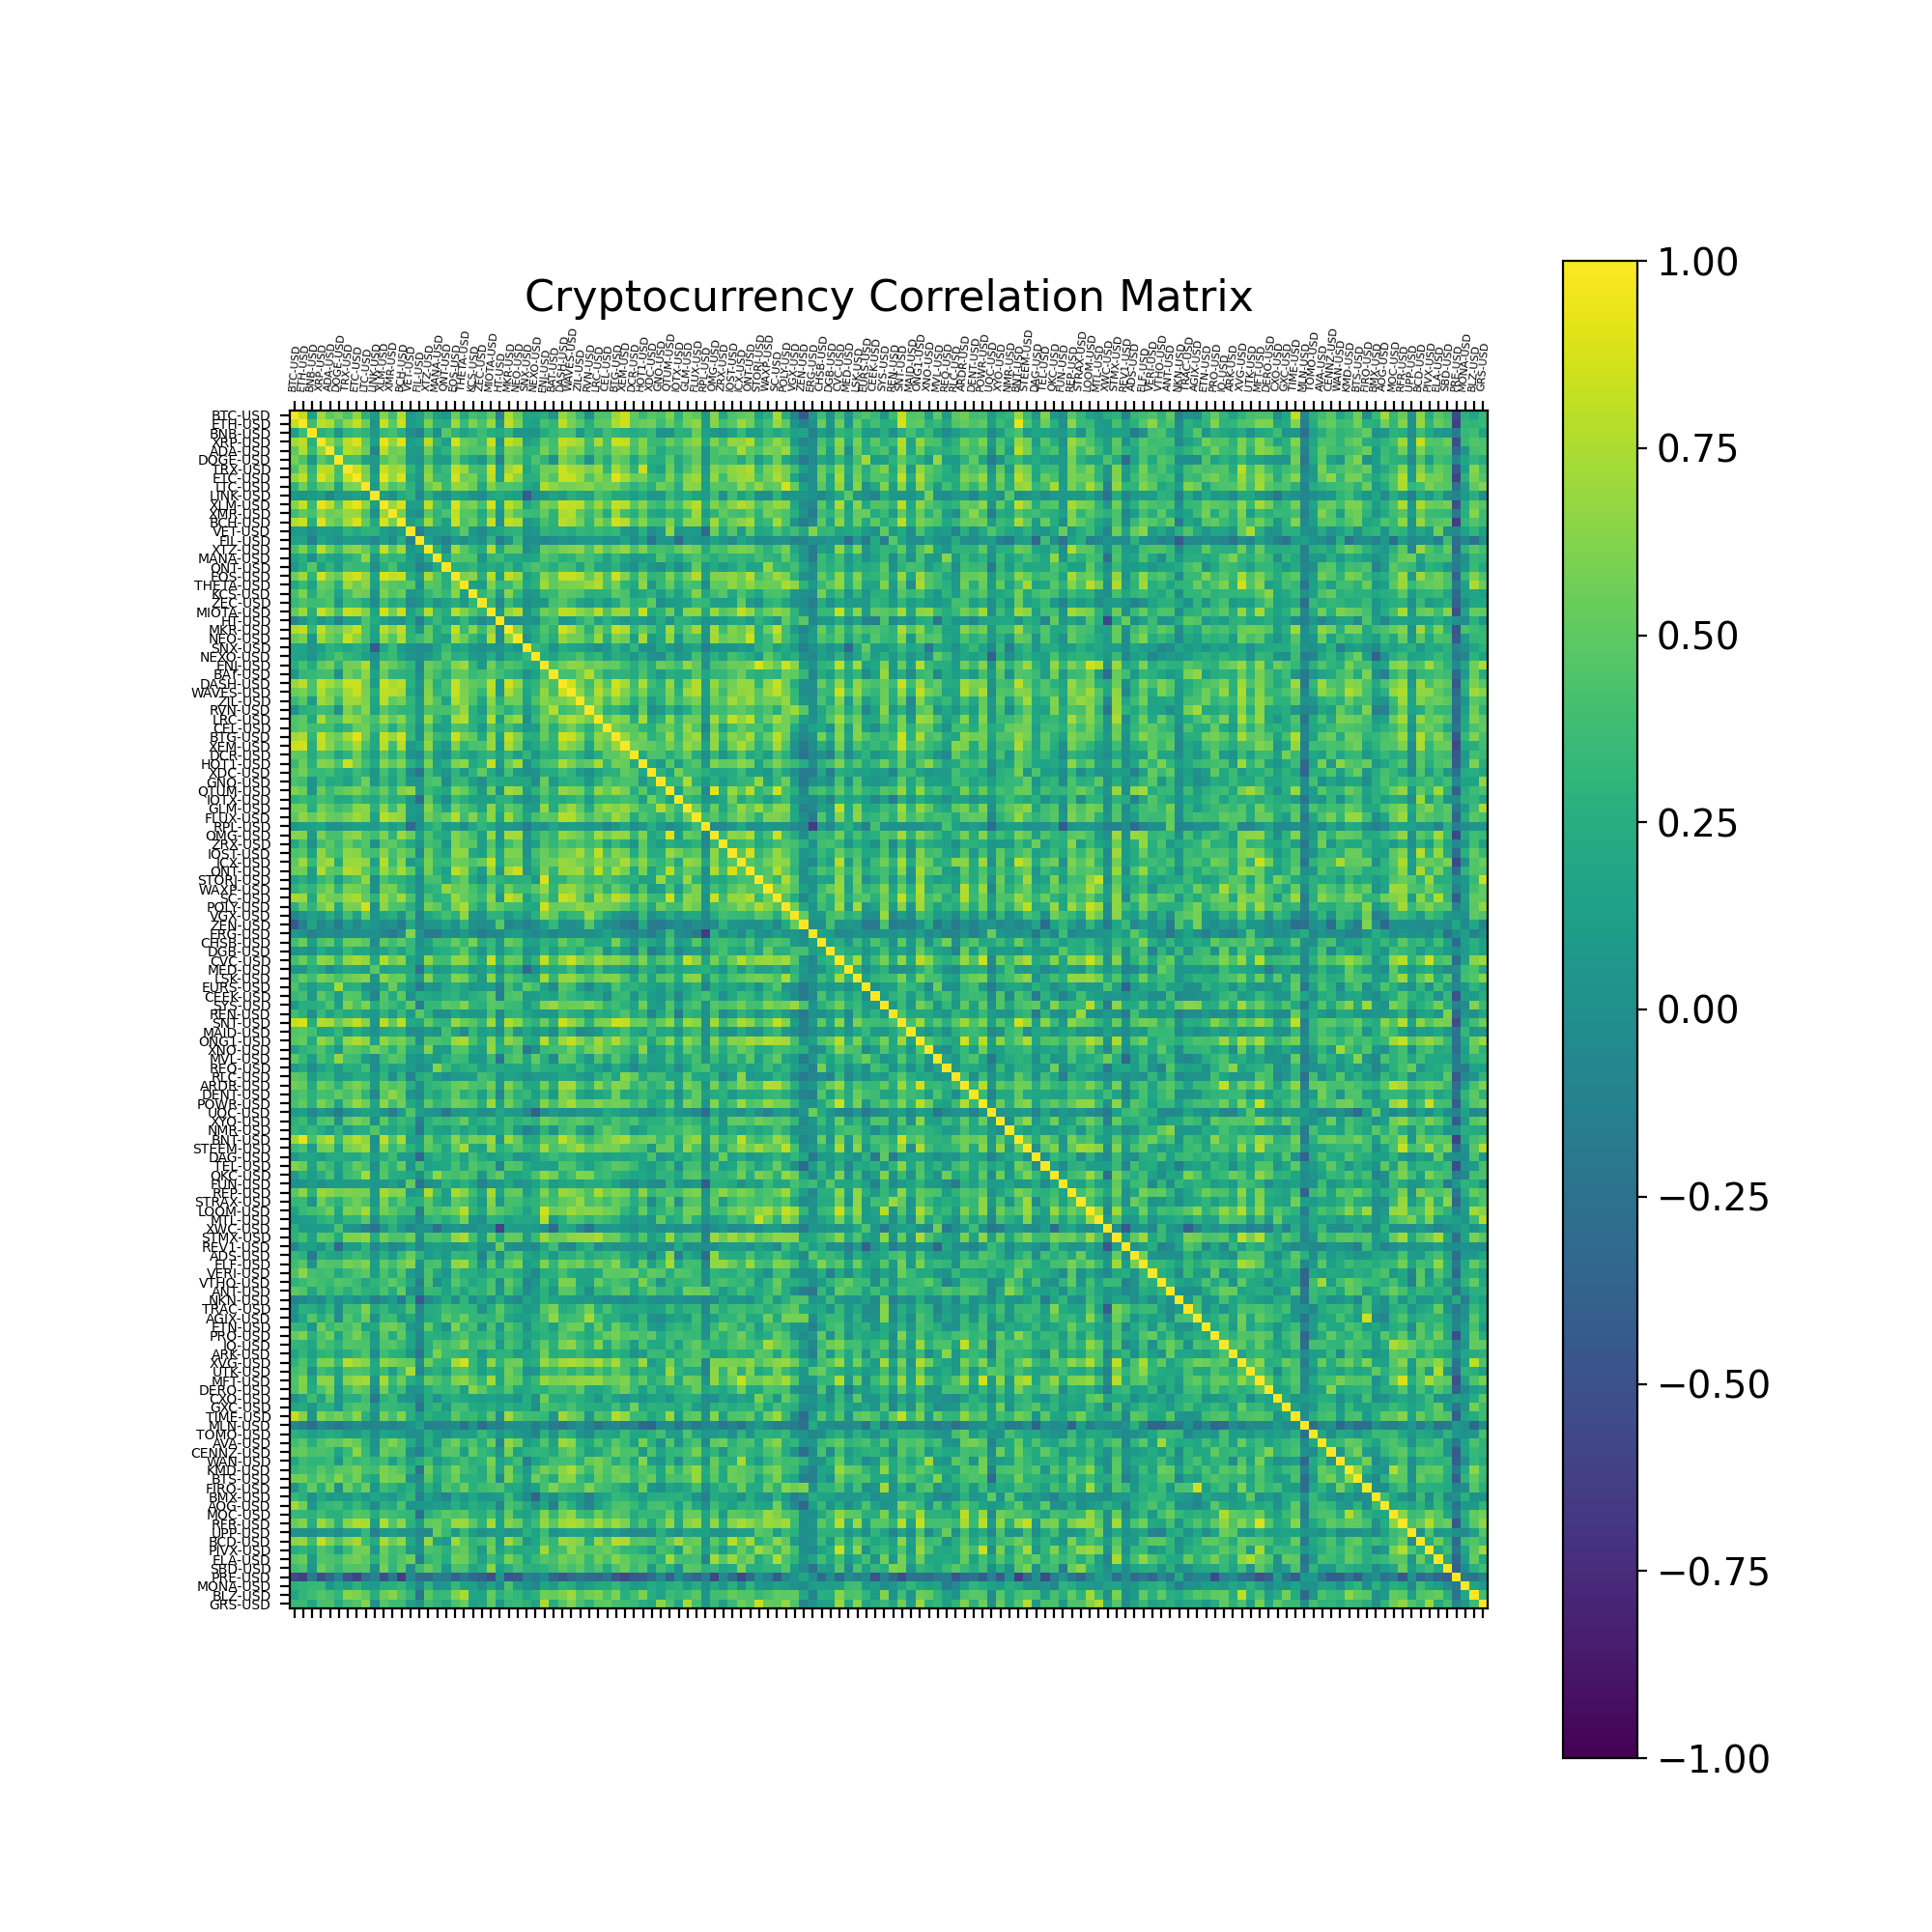

In [69]:
# plot correlation matrix with noise supression
# MS 0
f = plt.figure(figsize=(10,10))
plt.matshow(supcorrmatrix[53], fignum=f.number, vmin=-1, vmax=1)
plt.xticks(range(rmatrixlist[10].select_dtypes(['number']).shape[1]), rmatrixlist[10].select_dtypes(['number']).columns, fontsize=4, rotation=85)
plt.yticks(range(rmatrixlist[10].select_dtypes(['number']).shape[1]), rmatrixlist[10].select_dtypes(['number']).columns, fontsize=5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Cryptocurrency Correlation Matrix', fontsize=16);

<IPython.core.display.Javascript object>


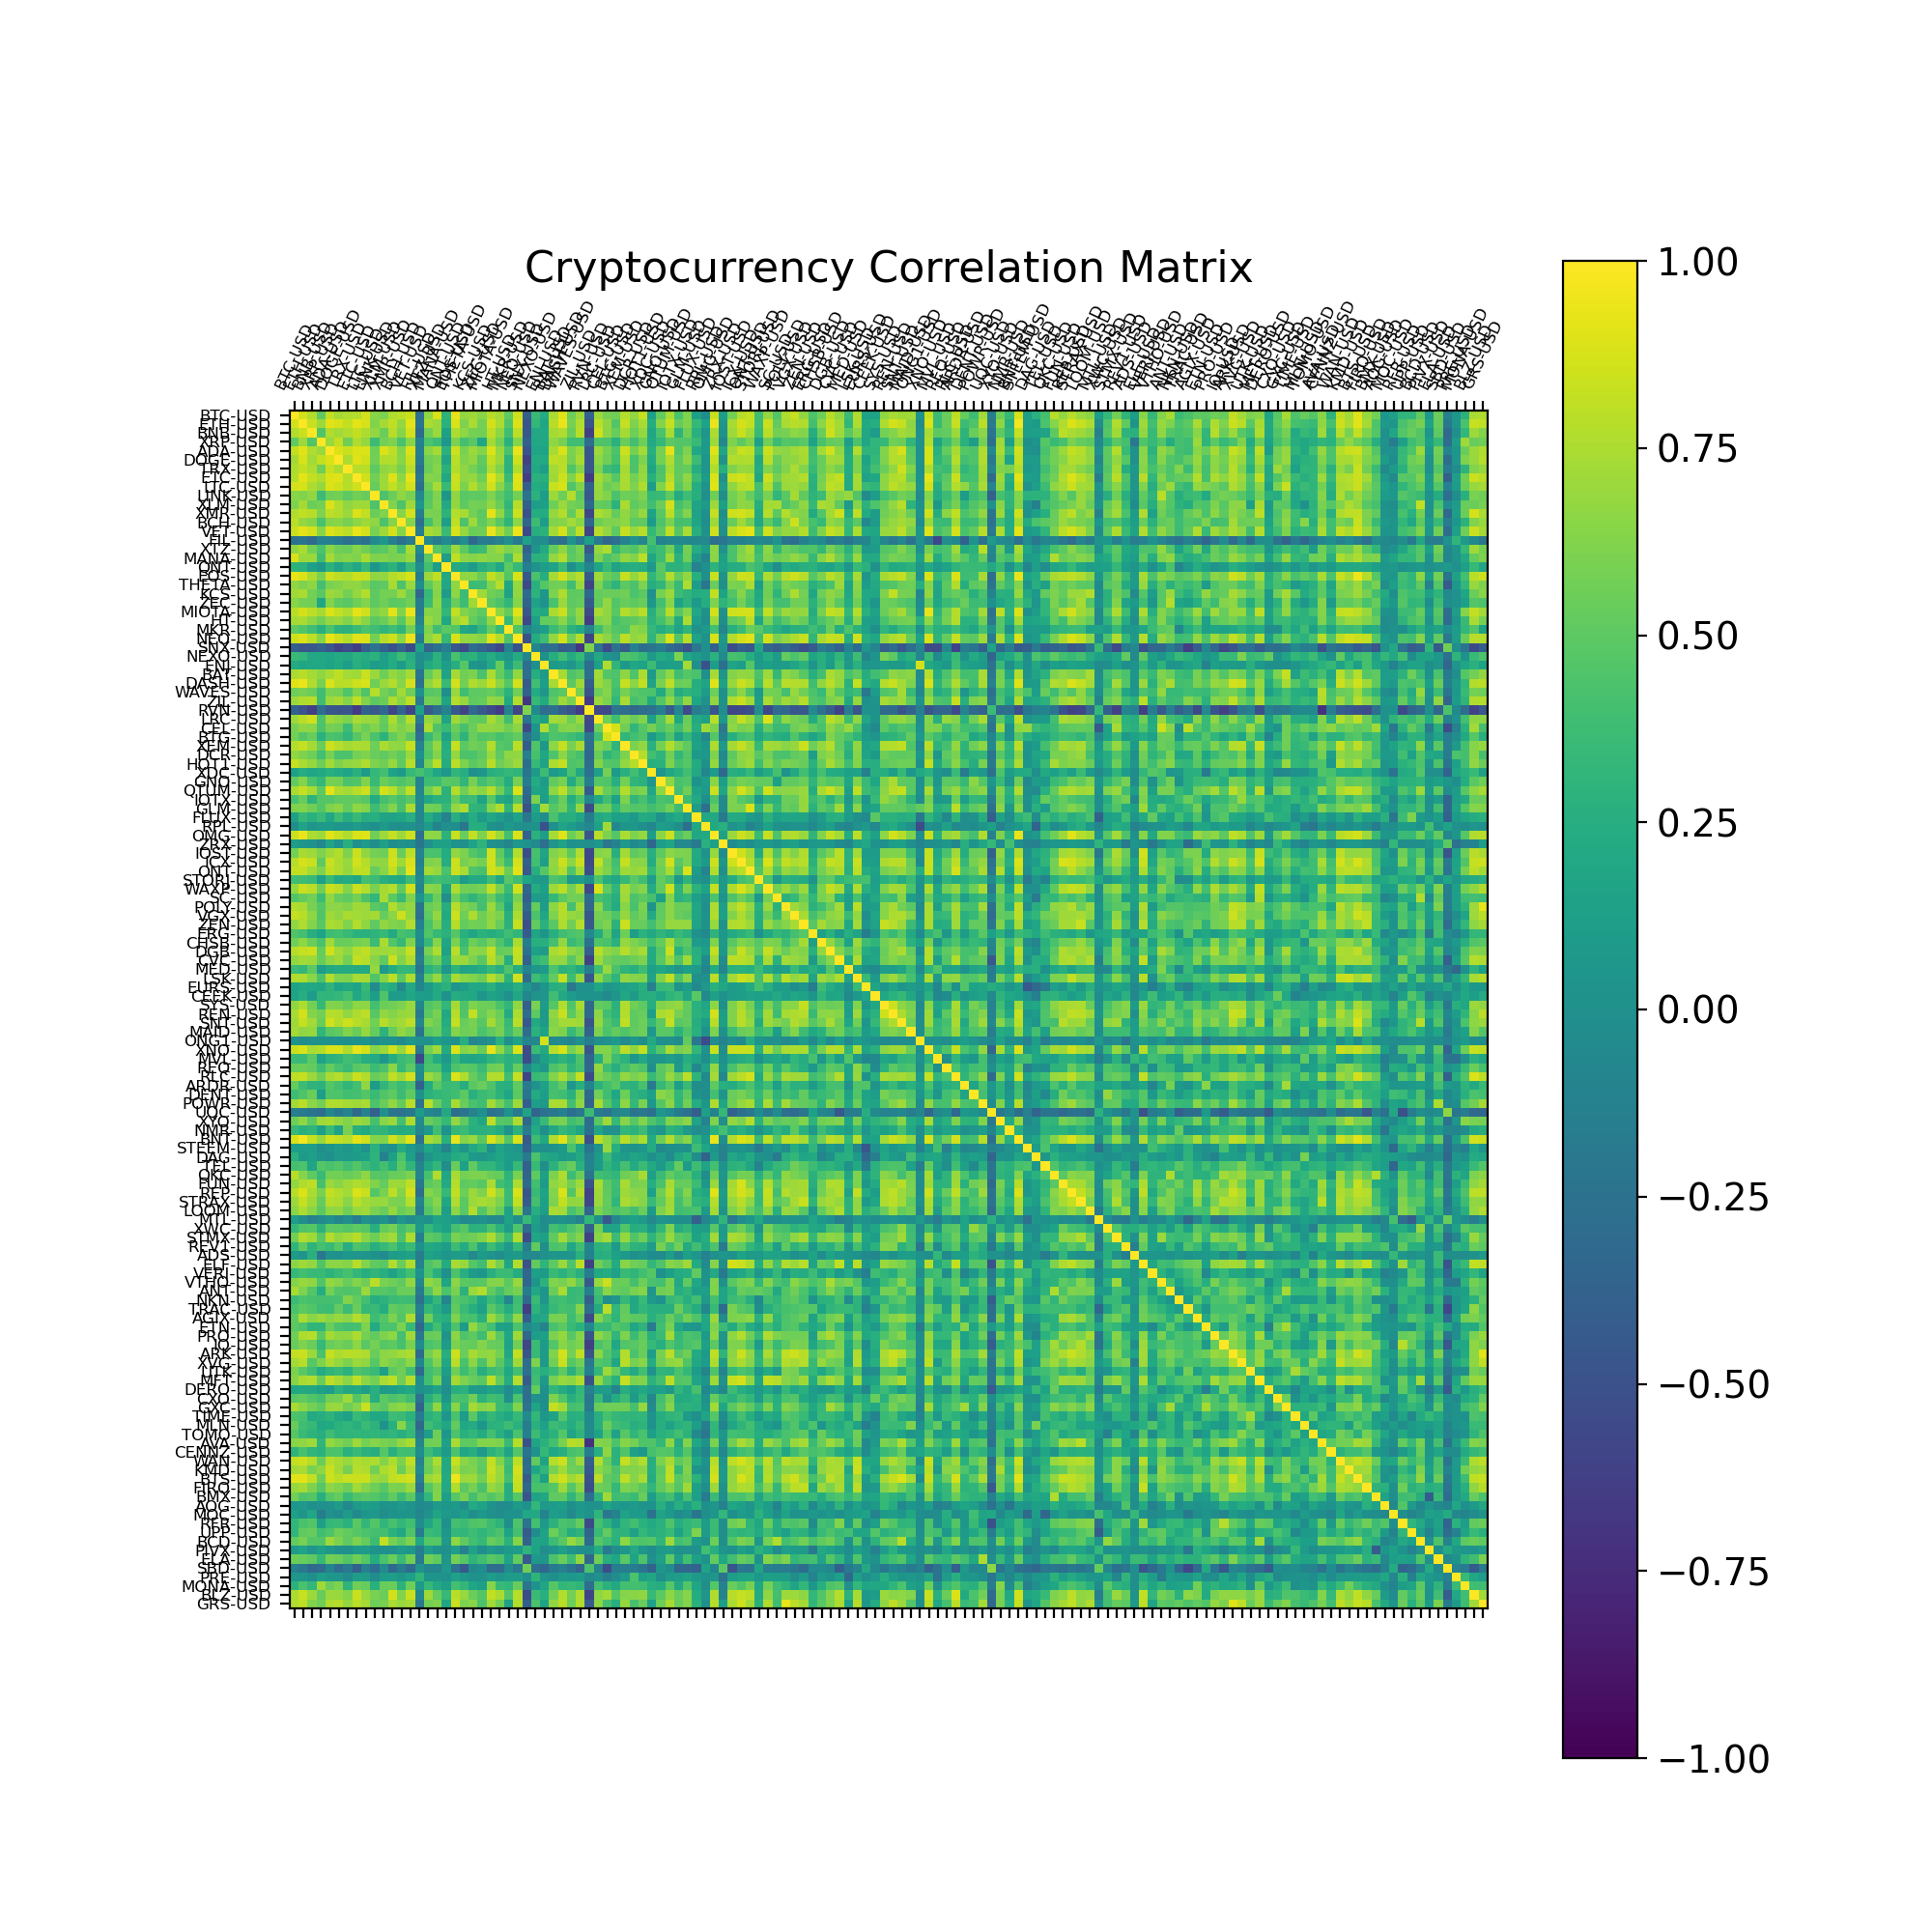

In [32]:
# plot correlation matrix with noise supression
# MS 1
f = plt.figure(figsize=(10,10))
plt.matshow(supcorrmatrix[1], fignum=f.number, vmin=-1, vmax=1)
plt.xticks(range(rmatrixlist[10].select_dtypes(['number']).shape[1]), rmatrixlist[10].select_dtypes(['number']).columns, fontsize=6, rotation=65)
plt.yticks(range(rmatrixlist[10].select_dtypes(['number']).shape[1]), rmatrixlist[10].select_dtypes(['number']).columns, fontsize=6)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Cryptocurrency Correlation Matrix', fontsize=16);

<IPython.core.display.Javascript object>


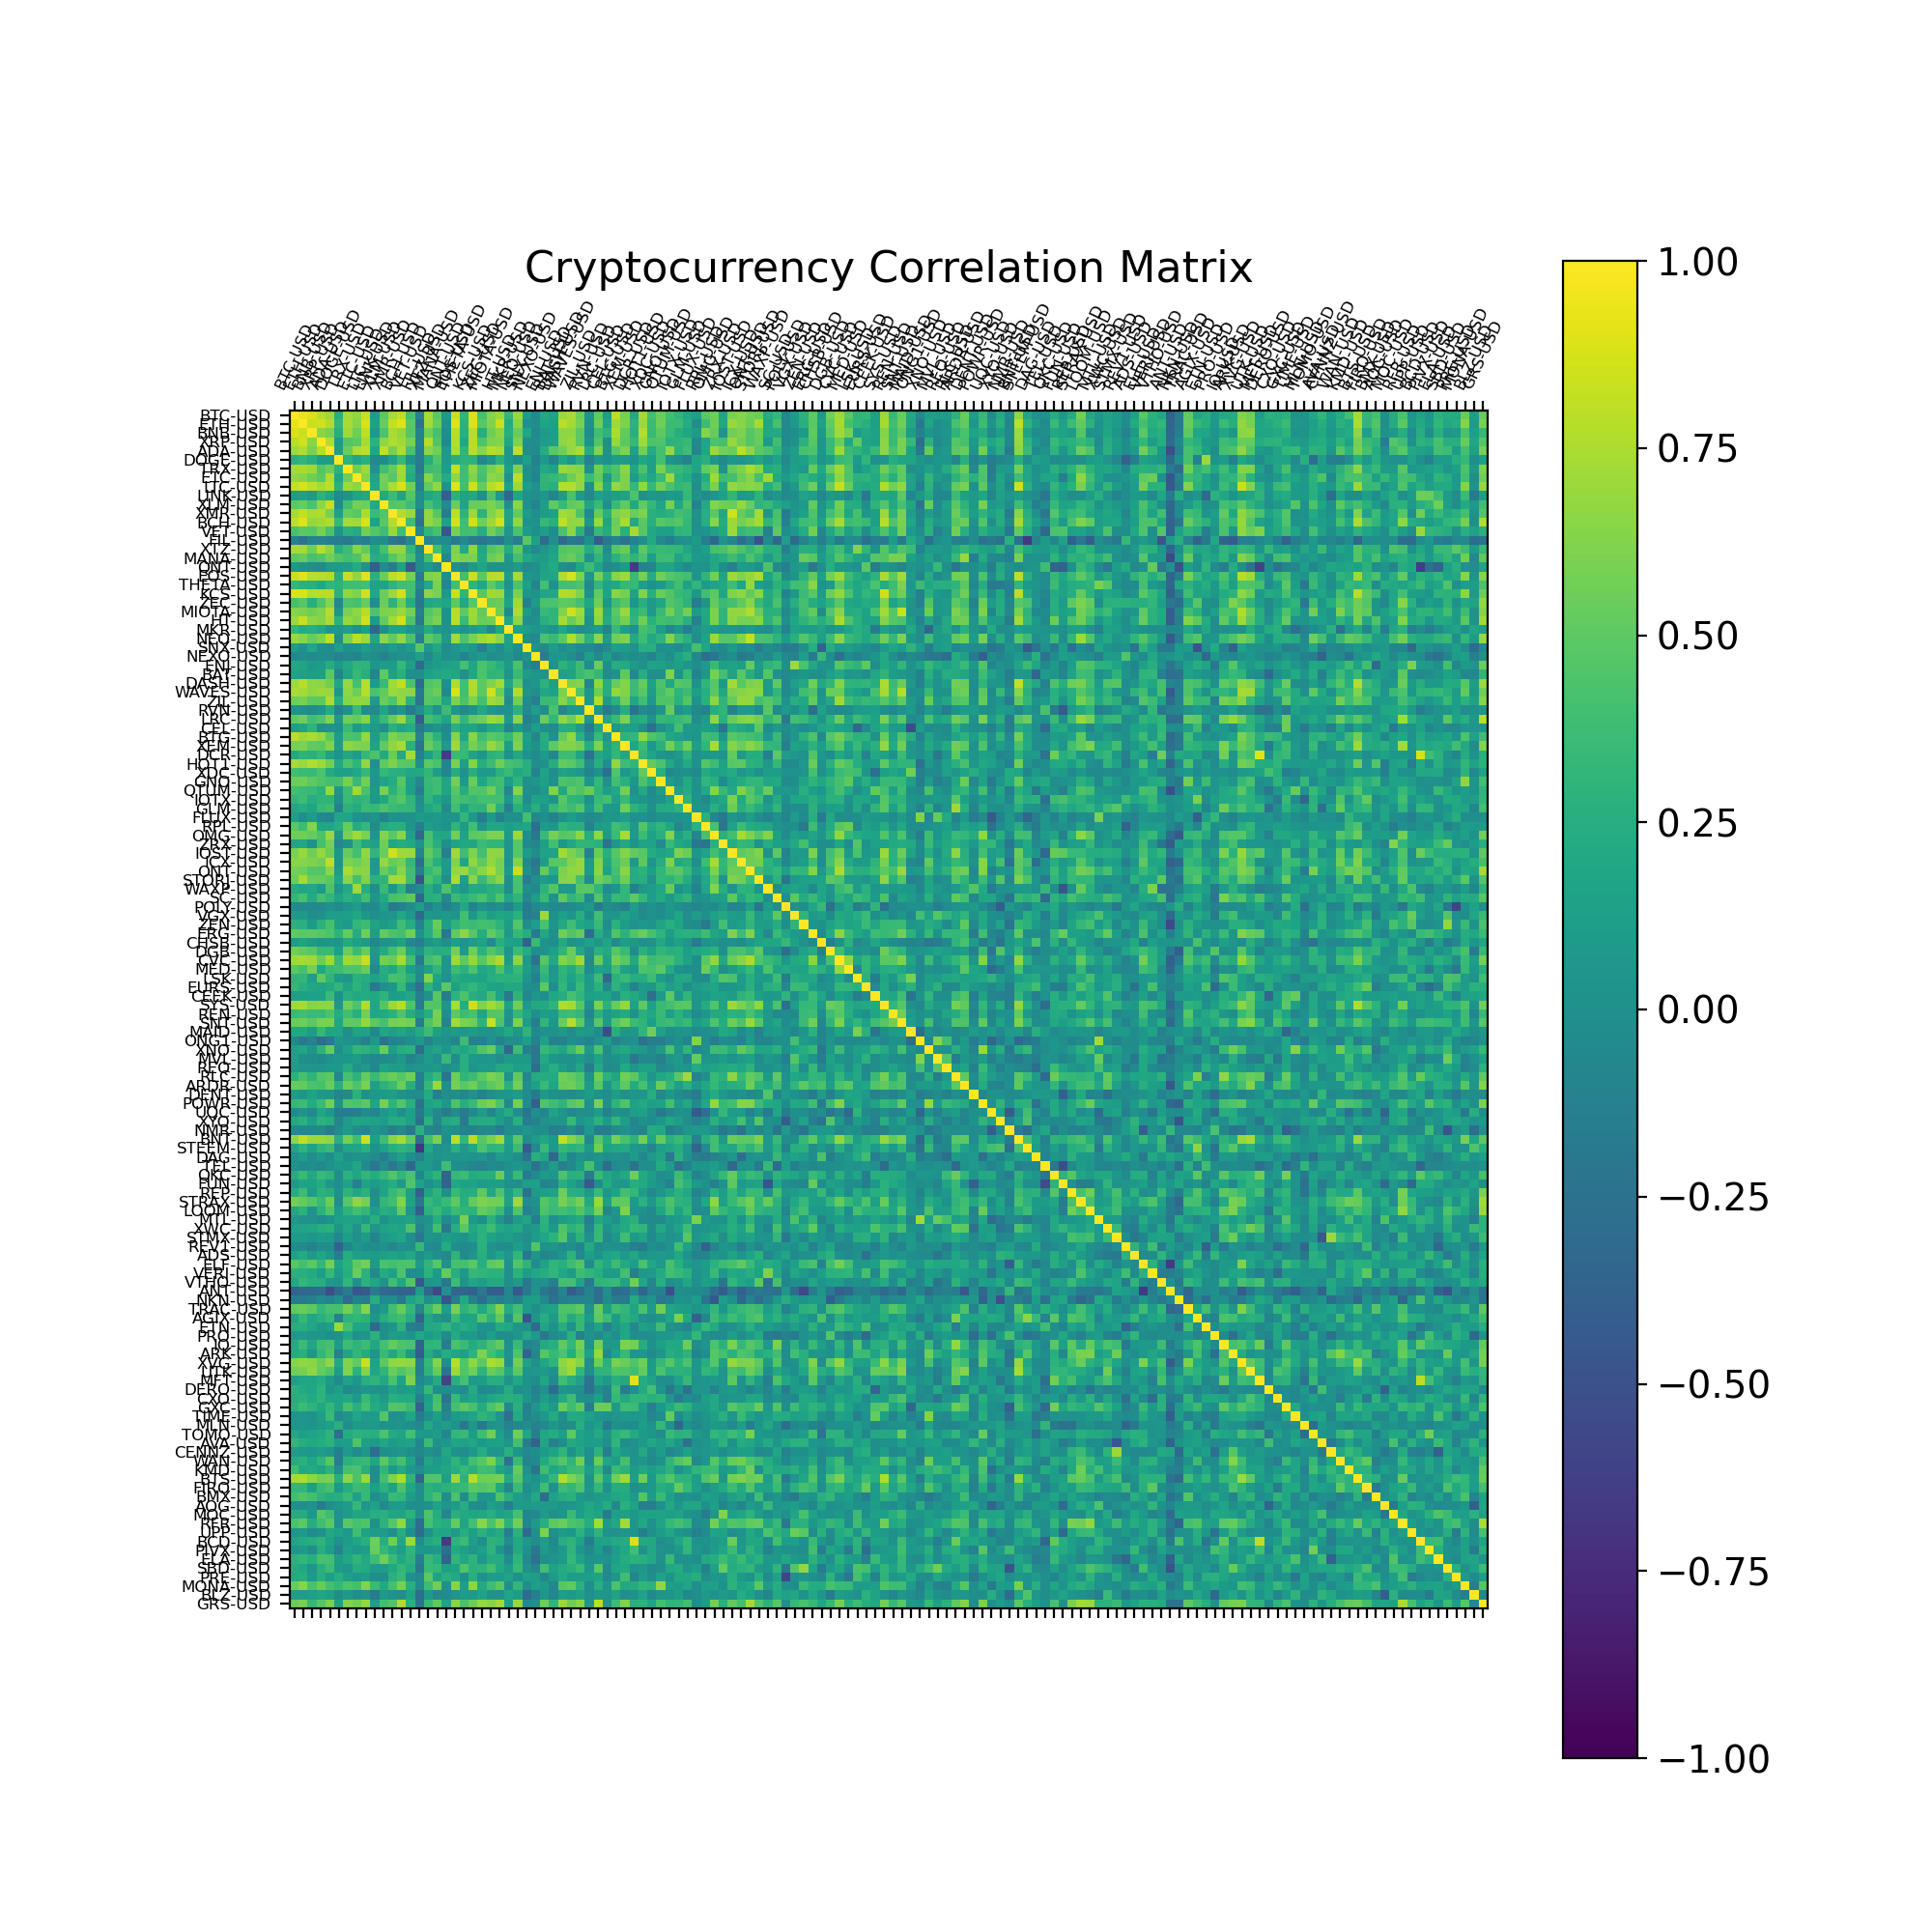

In [28]:
# plot correlation matrix with noise supression
# MS 2 (Rally State)
f = plt.figure(figsize=(10,10))
plt.matshow(supcorrmatrix[5], fignum=f.number, vmin=-1, vmax=1)
plt.xticks(range(rmatrixlist[10].select_dtypes(['number']).shape[1]), rmatrixlist[10].select_dtypes(['number']).columns, fontsize=6, rotation=65)
plt.yticks(range(rmatrixlist[10].select_dtypes(['number']).shape[1]), rmatrixlist[10].select_dtypes(['number']).columns, fontsize=6)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Cryptocurrency Correlation Matrix', fontsize=16);

<IPython.core.display.Javascript object>


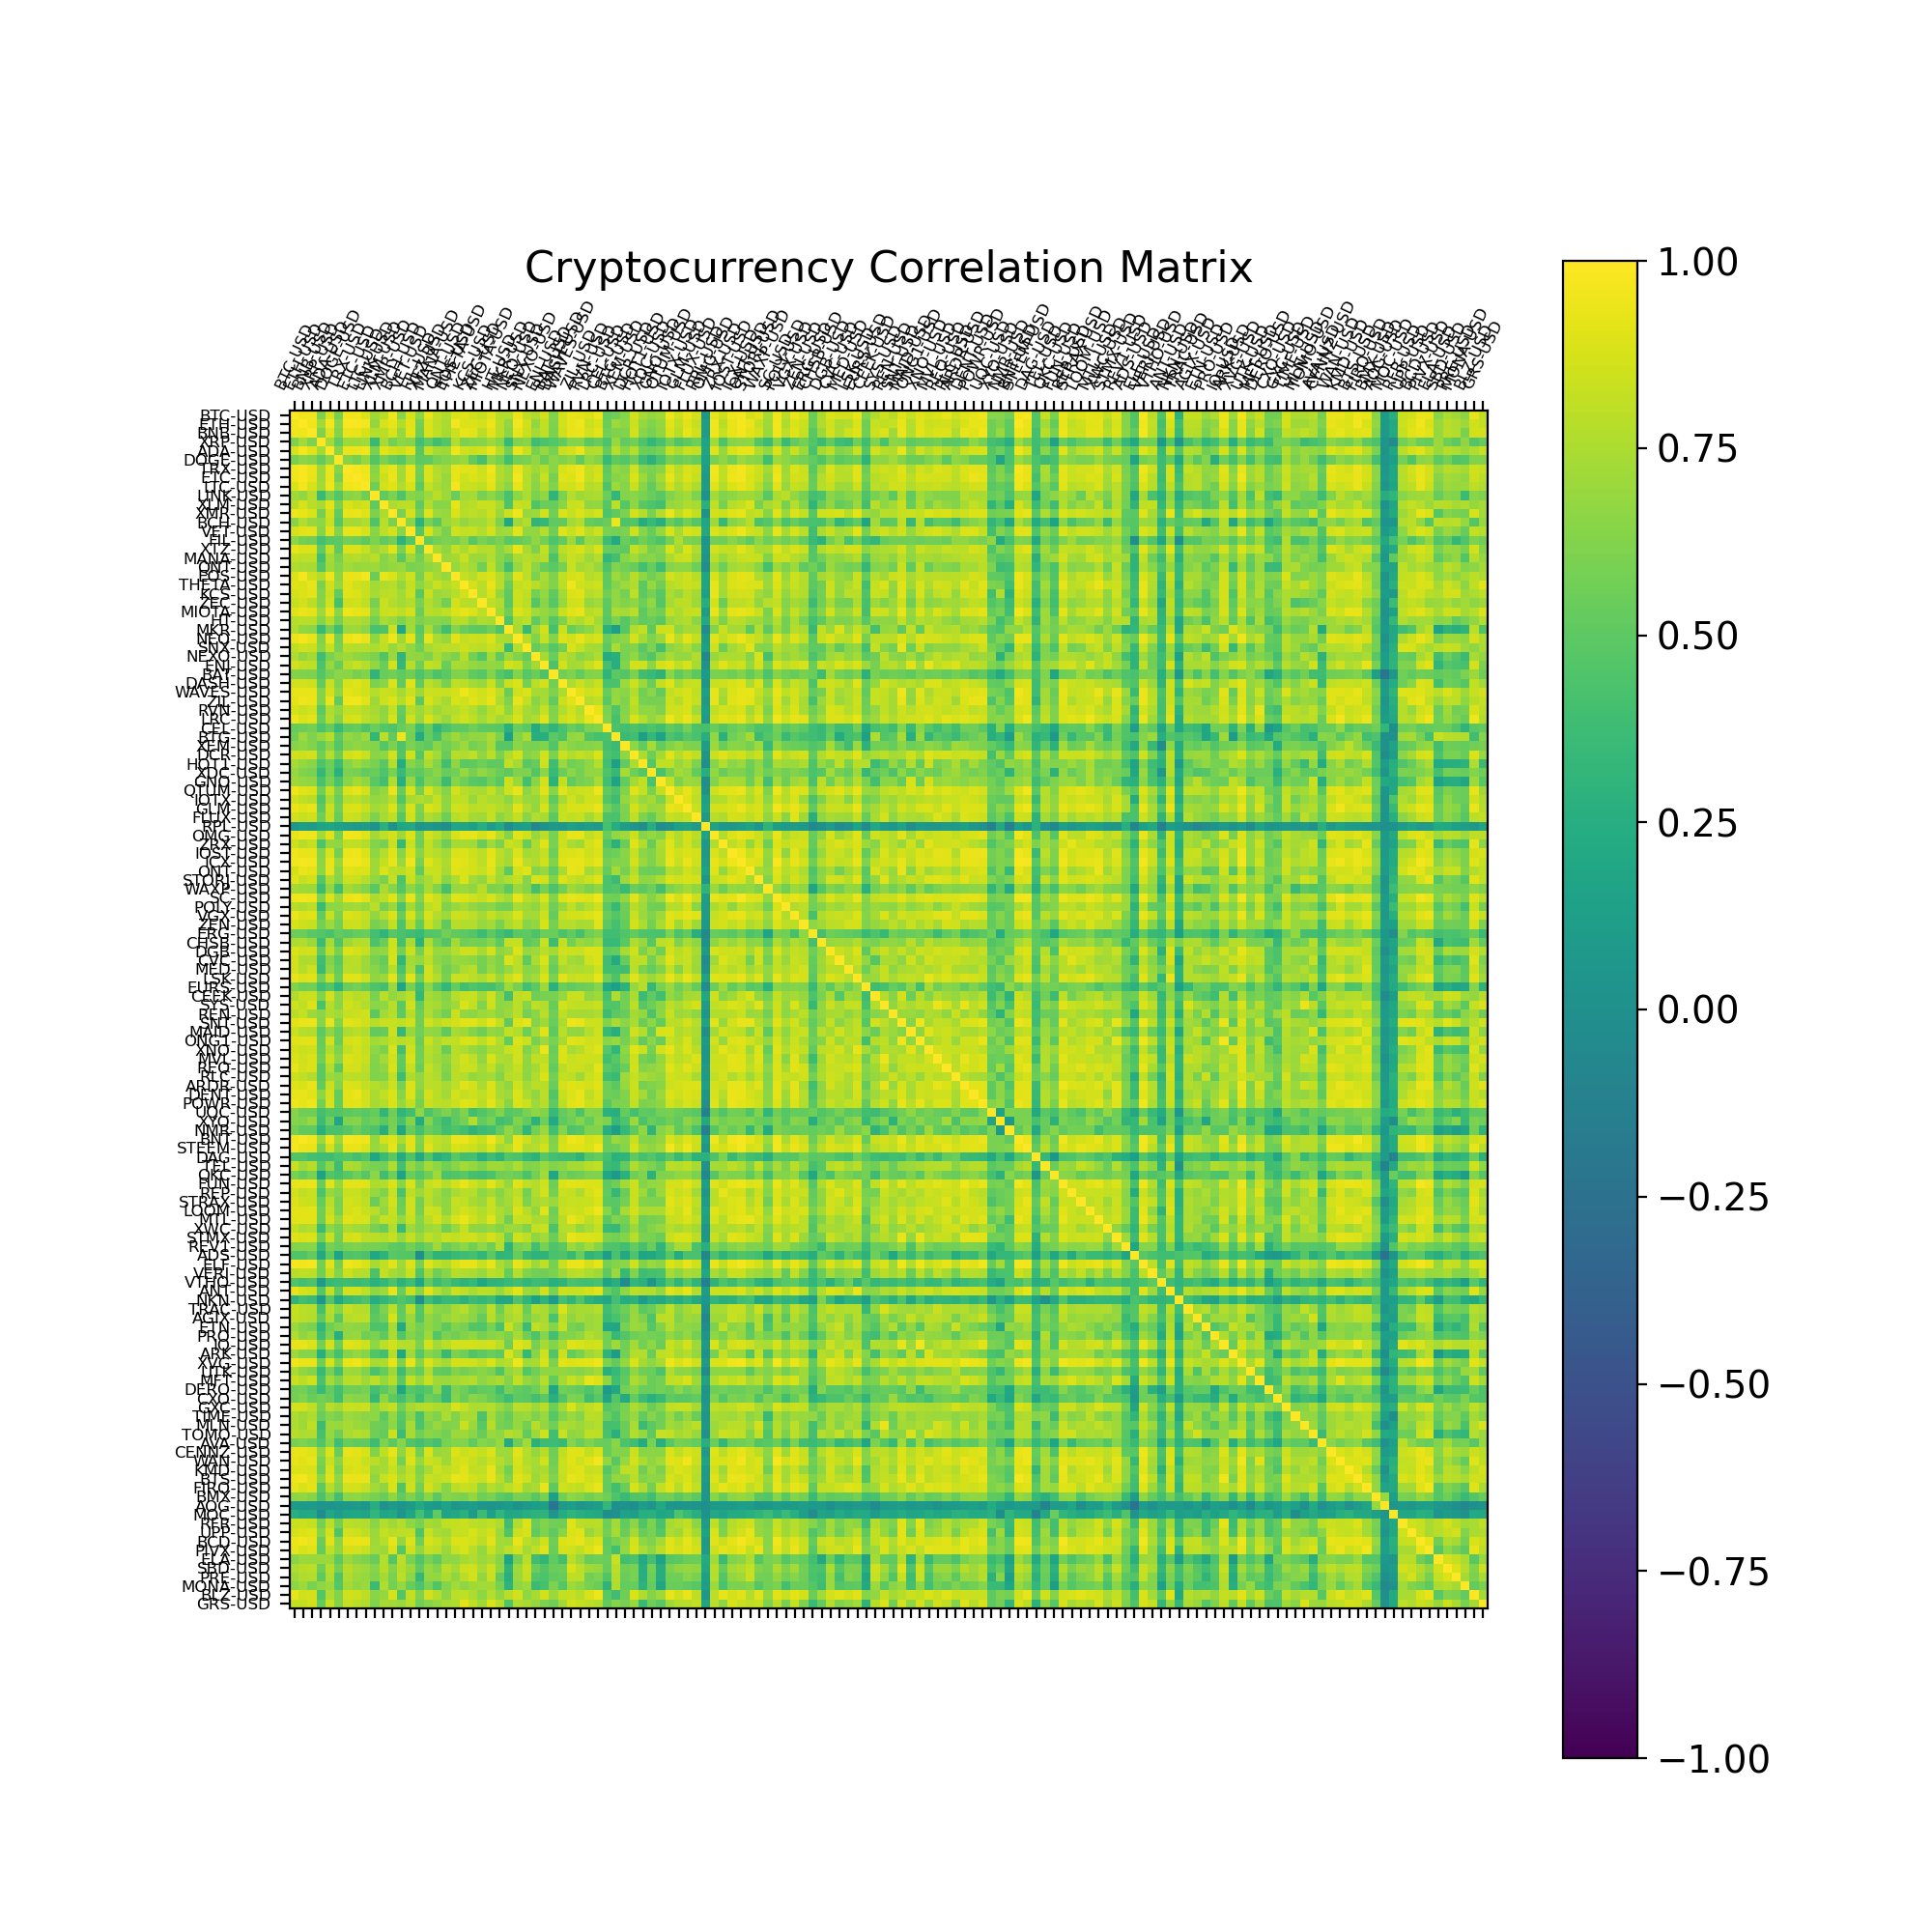

In [29]:
# plot correlation matrix with noise supression
# MS 3 (Crash State)
f = plt.figure(figsize=(10,10))
plt.matshow(supcorrmatrix[9], fignum=f.number,  vmin=-1, vmax=1)
plt.xticks(range(rmatrixlist[10].select_dtypes(['number']).shape[1]), rmatrixlist[10].select_dtypes(['number']).columns, fontsize=6, rotation=65)
plt.yticks(range(rmatrixlist[10].select_dtypes(['number']).shape[1]), rmatrixlist[10].select_dtypes(['number']).columns, fontsize=6)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Cryptocurrency Correlation Matrix', fontsize=16);

# Investigating Markovianity and determining transition rates

We can calculate empirical transition rates between market states. These probabilities of transition between states will be realiable if the system (market) can be modeled as a Markov chain and essentially has no memory effects. We compare the empirical probabilities of a market state occuring with the theoretical probabilities of a market state occuring. The theoretical probabilities are obtained from the eigenvalue problem of the empirical transition matrix. If the empirical and theoretical probabilities agree, the market can be regarded as a Markov chain.

The probabilities are extremely close. We therefore take our results to be reliable in the future. We give the transition probabilities down below.

In [12]:
def counttransitions(kmeansresult):
    results = list()
    czero = 0 
    cone = 0
    ctwo = 0
    cthree = 0
    cfour = 0
    s = len(kmeansresult)
    for i in range(s):
        if i == s-1:
            break
        elif kmeansresult[i] == 0:
            czero += 1
        elif kmeansresult[i] == 1:
            cone += 1
        elif kmeansresult[i] == 2:
            ctwo += 1
        elif kmeansresult[i] == 3:
            cthree += 1
        tup = (kmeansresult[i], kmeansresult[i+1])
        results.append(tup)
    counts = Counter(results)
    return (czero, cone, ctwo, cthree, counts)

In [67]:
counttransitions(y_km)

(66,
 82,
 67,
 72,
 Counter({(1, 1): 58,
          (1, 2): 15,
          (2, 2): 46,
          (2, 1): 13,
          (1, 3): 5,
          (3, 3): 58,
          (3, 1): 4,
          (1, 0): 4,
          (0, 0): 45,
          (0, 2): 6,
          (2, 0): 8,
          (0, 1): 6,
          (3, 0): 10,
          (0, 3): 9}))

In [9]:
#transition rate matrix for eigenvalue problem, obtained from the function above
transmatrix = np.array([[45/66,6/66,6/66,9/66], [4/82, 58/82, 15/82,5/82], [8/67, 13/67, 46/67,0], 
                       [10/72,4/72,0, 58/72]])
transpose = np.transpose(transmatrix)
en, vn = LA.eig(transpose)
print(en)
print(vn)
unnorm = vn[:,0]
normalization = sum(unnorm)
normed = unnorm/normalization
#gotten from eigenvalue problem
print('These are the theoretical probabilities of getting each Market State', normed)
# gotten by doing counts_i/ total_counts
print('These are the empirical probabilities of getting each Market State', [66/287, 82/287,67/287,72/287])
print('These probabilities are really close so we treat the system as a Markov chain')

[1.         0.48982441 0.58682403 0.80460954]
[[-0.47838394 -0.51982116 -0.82437109  0.18002821]
 [-0.54961934 -0.44846585  0.39624793 -0.41404287]
 [-0.45952292  0.6571673   0.02464781 -0.50298336]
 [-0.50784453  0.31111971  0.40347536  0.73699802]]
These are the theoretical probabilities of getting each Market State [0.23974689 0.27544723 0.23029451 0.25451137]
These are the empirical probabilities of getting each Market State [0.22996515679442509, 0.2857142857142857, 0.23344947735191637, 0.2508710801393728]
These probabilities are really close so we treat the system as a Markov chain


# The transition probabilities are given by this matrix:

In [10]:
print(transmatrix)

[[0.68181818 0.09090909 0.09090909 0.13636364]
 [0.04878049 0.70731707 0.18292683 0.06097561]
 [0.11940299 0.19402985 0.68656716 0.        ]
 [0.13888889 0.05555556 0.         0.80555556]]


We can look at the average daily return when in a specific market state.

In [34]:
#gives % avg return for a given crypto
def avgforms(y_km, crypto):
    mszc = 0
    msoc = 0
    mstc = 0
    msthc = 0
    czero = 0 
    cone = 0
    ctwo = 0
    cthree = 0
    for i in range(len(y_km)):
        if y_km[i] == 0:
            czero += 1
            mszc += rmatrixlist[i][crypto].mean()
        elif y_km[i] == 1:
            msoc += rmatrixlist[i][crypto].mean()
            cone += 1
        elif y_km[i] == 2:
            mstc += rmatrixlist[i][crypto].mean()
            ctwo += 1
        elif y_km[i] == 3:
            msthc += rmatrixlist[i][crypto].mean()
            cthree += 1
    return ((np.exp(mszc)-1)*100/czero, (np.exp(msoc)-1)*100/cone, (np.exp(mstc)-1)*100/ctwo, (np.exp(msthc)-1)*100/cthree)

In [14]:
# gives % avg return for the entire market
def avgformsall(y_km):
    mszc = 0
    msoc = 0
    mstc = 0
    msthc = 0
    czero = 0 
    cone = 0
    ctwo = 0
    cthree = 0
    tracker = defaultdict(lambda: list())
    for i in range(len(y_km)):
        if y_km[i] == 0:
            czero += 1
            mszc += rmatrixlist[i].mean().mean()
            tracker[0].append(rmatrixlist[i].mean().mean())
        elif y_km[i] == 1:
            msoc += rmatrixlist[i].mean().mean()
            cone += 1
            tracker[1].append(rmatrixlist[i].mean().mean())
        elif y_km[i] == 2:
            mstc += rmatrixlist[i].mean().mean()
            ctwo += 1
            tracker[2].append(rmatrixlist[i].mean().mean())
        elif y_km[i] == 3:
            msthc += rmatrixlist[i].mean().mean()
            cthree += 1
            tracker[3].append(rmatrixlist[i].mean().mean())
    #print(tracker)
    return ((np.exp(mszc)-1)*100/czero, (np.exp(msoc)-1)*100/cone, (np.exp(mstc)-1)*100/ctwo, (np.exp(msthc)-1)*100/cthree)

In [20]:
#Shows the average daily percent return per market state across the entire market
avgformsall(y_km)

(0.4139075417962849,
 0.10656154981050918,
 1.0569410881882957,
 -0.7471073729527477)

In [37]:
#Shows the average daily percent return per market state for BTC specifically
avgforms(y_km, 'BTC-USD')

(0.34434623598369496,
 0.2605665308682952,
 0.6342785085761032,
 -0.5719311246150238)

In [38]:
#Shows the average daily percent return per market state for ETH specifically
avgforms(y_km, 'ETH-USD')

(0.6486871014941868, 0.23329652965004785, 1.09823751545026, -0.694754571998904)

# Some extra graphs to see effects of noise supression and how appropriate k's were chosen

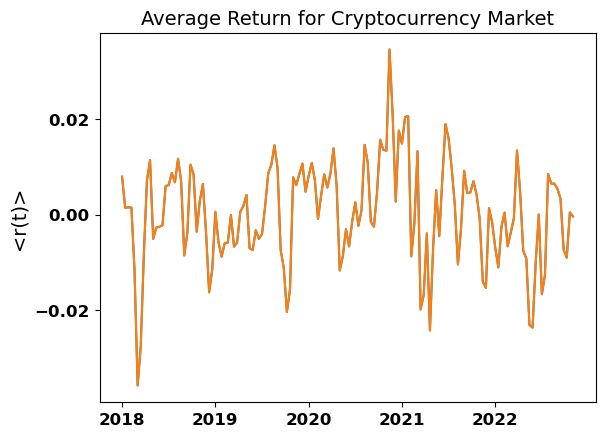

In [77]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
# Plot average return 
fig, ax = plt.subplots()
xcorr = np.arange(0,len(corraverages))
plt.style.use('default')
plt.plot(raverages)
plt.ylabel("<r(t)>", fontsize=14)
plt.title('Average Return for Cryptocurrency Market', fontsize=14)
labels = np.linspace(2018, 2023, endpoint=True, num=len(xcorr), dtype=int)
plt.plot(xcorr, raverages)
plt.xticks(xcorr, labels)
plt.locator_params(nbins=5)

plt.show()

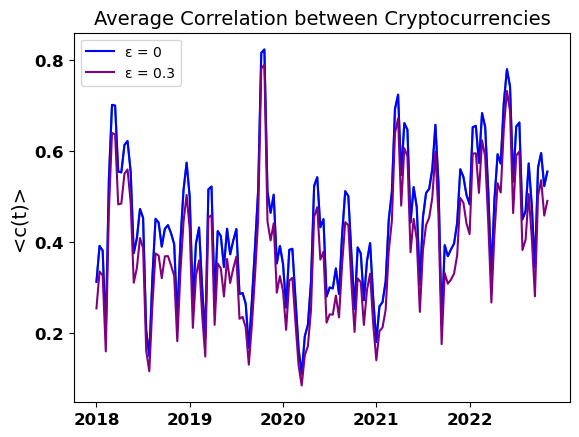

In [86]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
# Plot average correlation 
fig, ax = plt.subplots()
xcorr = np.arange(0,len(corraverages))
plt.style.use('default')
plt.plot(corraverages)
plt.ylabel("<c(t)>", fontsize=14)
plt.title('Average Correlation between Cryptocurrencies', fontsize=14)
labels = np.linspace(2018, 2023, endpoint=True, num=len(xcorr), dtype=int)
plt.plot(xcorr, corraverages, color='blue', label='\u03B5 = 0')
plt.plot(xcorr, supcorraverages, color='purple', label='\u03B5 = 0.3')
plt.xticks(xcorr, labels)
plt.locator_params(nbins=5)
plt.legend()

plt.show()

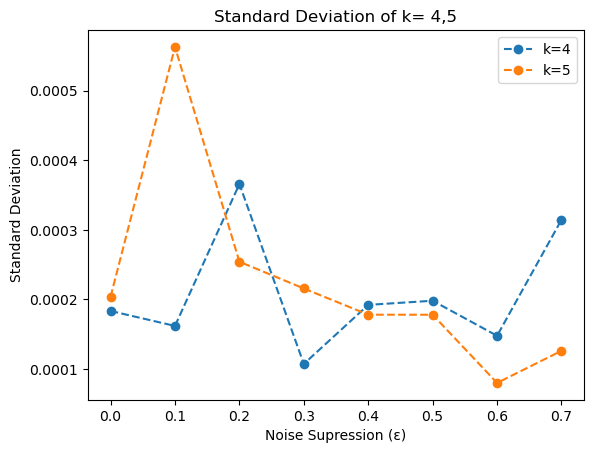

In [279]:
plt.plot(epoints, std4, label = 'k=4', linestyle = '--', marker = 'o')
plt.plot(epoints, std5, label = 'k=5', linestyle = '--', marker = 'o')
plt.title('Standard Deviation of k= 4,5')
plt.ylabel('Standard Deviation')
plt.xlabel('Noise Supression (\u03B5)')
plt.legend()
plt.show()